In [1]:
# prompt: truy cập google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from statistics import mean
import joblib



import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset/Cycling_data/Raw_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/dataset/Cycling_data/Raw_data/Active 2024_11_27_10_4_25.txt


In [ ]:
from pathlib import Path
work_dir = Path('/content/drive/MyDrive/dataset/Cycling_data')

In [ ]:
try:
    os.mkdir(work_dir/'figures')
    os.mkdir(work_dir/'models')
    os.mkdir(work_dir/'saved_objects')
except:
    print("Already have directory!")

Already have directory!


# **Chuyển data sang csv**

In [ ]:
# LOAD DATA
# Specify the path to your file
data_path = work_dir/"Raw_data/Active 2024_11_22_10_49_28.txt"
# Check data
with open(data_path, "r") as file:
    first_line = file.readline().strip()  # Reads the first line and removes any trailing newline characters
    l = first_line.split("\t")
    print(l)

['0.000', '0', '-29.36', '-16.76', '0', '0']


In [ ]:
# Specify the path to your file
data_path = work_dir/"Raw_data/Passive 2024_11_22_10_53_29.txt"
# Check data
with open(data_path, "r") as file:
    first_line = file.readline().strip()  # Reads the first line and removes any trailing newline characters
    l = first_line.split("\t")
    print(l)

['0.000', '0', '-29.64', '-14.92', '0', '0']


`Bởi vì file có định dạng thô, khó xử lý dữ liệu nên cần thông qua bước tổng hợp dữ liệu sang file csv để tiện cho các thao tác dữ liệu!`







In [ ]:
# prompt: xóa file /content/drive/MyDrive/dataset/Cycling_data/cycling.csv

!rm /content/drive/MyDrive/dataset/Cycling_data/cycling.csv


In [ ]:
fields = ['date','t','Tau_Motor','Tau_1', 'Tau_2', 'vel', 'encoder_count', 'mode', 'level', 'turn']
outputfile = work_dir/"cycling.csv"
with open(outputfile, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields)
    writer.writeheader()

def updateLog(date,t,Tau_Motor,Tau_1,Tau_2,vel,encoder_count,mode,level, turn):
    list_append = [{'date':'{}'.format(date),'t':'{:.03f}'.format(t),'Tau_Motor':'{:.02f}'.format(Tau_Motor),
                    'Tau_1': '{:.02f}'.format(Tau_1), 'Tau_2': '{:.02f}'.format(Tau_2), 'vel': '{:.02f}'.format(vel),
                    'encoder_count': '{:.02f}'.format(encoder_count), 'mode': '{}'.format(mode), 'level': '{}'.format(level), 'turn': '{}'.format(turn)}]
    with open(outputfile, 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        writer.writerows(list_append)
        csvfile.close()

In [ ]:
turn  = 0
for dirname, _, filenames in os.walk(work_dir/'Raw_data/'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)
        filename = filename.replace(".txt", "")
        name = filename.split(" ")
        name = name[1]
        strDate = name.split("_")
        print(strDate)
        with open(file_path, "r") as file:
            l = []
            for line in file:
                line = line.strip()
                if line[0].isdigit():
                    l.append(line.split("\t"))
                else:
                    mode = line.split(";")
                    print("Catch!")
                    # print(l)
                    print(mode)
                    turn+=1
                    date = "{}:{}:{} - {}/{}/{}".format(strDate[3], strDate[4], strDate[5], strDate[2], strDate[1], strDate[0])
                    for i in l:
                        updateLog(date, float(i[0]), float(i[1]), float(i[2]), float(i[3]), float(i[4]), float(i[5]), mode[0], mode[1][-1], turn)
                    l = []

/content/drive/MyDrive/dataset/Cycling_data/Raw_data/Passive 2024_11_27_10_0_24.txt
['2024', '11', '27', '10', '0', '24']
Catch!
['Passive', ' Level 1']
Catch!
['Passive', ' Level 2']
Catch!
['Passive', ' Level 3']
Catch!
['Passive', ' Level 4']
Catch!
['Passive', ' Level 5']
Catch!
['Passive', ' Level 4']
Catch!
['Passive', ' Level 3']
Catch!
['Passive', ' Level 2']
Catch!
['Passive', ' Level 1']
Catch!
['Passive', ' Level 0']
/content/drive/MyDrive/dataset/Cycling_data/Raw_data/Active 2024_11_27_10_4_25.txt
['2024', '11', '27', '10', '4', '25']
Catch!
['Active', ' Level 1']
Catch!
['Active', ' Level 2']
Catch!
['Active', ' Level 3']
Catch!
['Active', ' Level 4']
Catch!
['Active', ' Level 5']
Catch!
['Active', ' Level 4']
Catch!
['Active', ' Level 3']
Catch!
['Active', ' Level 2']
Catch!
['Active', ' Level 1']
Catch!
['Active', ' Level 0']
Catch!
['Active', ' Level 1']
Catch!
['Active', ' Level 0']
Catch!
['Active', ' Level 5']
Catch!
['Active', ' Level 3']
Catch!
['Active', ' Level 2

In [ ]:
# LOAD DATA
raw_data = pd.read_csv(r'/content/drive/MyDrive/dataset/Cycling_data/cyclingLabel.csv')

Config label

In [ ]:
# prompt: từ raw_data, tạo vòng for rà soát từng hàng dữ liệu, hàng nào có dữ liệu cột 'period' thì giữ nguyên, hàng nào trống dữ liệu cột này thì điền dữ liệu từ hàng trước đó vào

# Fill NaN values in 'period' column with the previous valid value
previous_period = None
previous_push_leg = None
for index, row in raw_data.iterrows():
    if pd.notna(row['period']):
        previous_period = row['period']
        previous_push_leg = row['push_leg']
    else:
        raw_data.loc[index, 'period'] = previous_period
        raw_data.loc[index, 'push_leg'] = previous_push_leg

# **1.   Preview data**

In [ ]:
# DISCOVER THE DATA TO GAIN INSIGHTS

# Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())
print('\n____________ Some first data examples ____________')
print(raw_data.head(3))
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1136 non-null   object 
 1   t                1136 non-null   float64
 2   Tau_Motor        1136 non-null   float64
 3   Tau_1            1136 non-null   float64
 4   Tau_2            1136 non-null   float64
 5   vel              1136 non-null   float64
 6   encoder_count    1136 non-null   int64  
 7   mode             1136 non-null   object 
 8   level            1136 non-null   int64  
 9   turn             1136 non-null   int64  
 10  period           1136 non-null   int64  
 11  push_leg         1136 non-null   object 
 12  degree           1136 non-null   float64
 13  phase            1136 non-null   int64  
 14  Tau_Motor_deriv  1136 non-null   float64
 15  Tau_1_deriv      1136 non-null   float64
 16  Tau_2_deriv      113

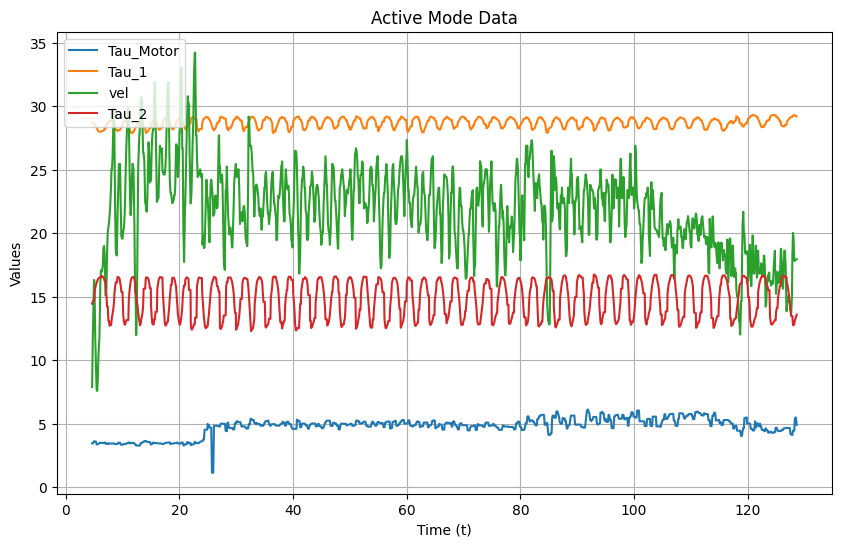

In [ ]:
# prompt: Generate column ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2'] of raw_data['mode'] = Passive in a diagram with x-axis is column "t"

import matplotlib.pyplot as plt

# Filter data for 'mode' == 'Passive'
active_data = raw_data[raw_data['mode'] == 'Active']

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(active_data['t'], active_data['Tau_Motor'], label='Tau_Motor')
plt.plot(active_data['t'], active_data['Tau_1'], label='Tau_1')
plt.plot(active_data['t'], active_data['vel'], label='vel')
plt.plot(active_data['t'], active_data['Tau_2'], label='Tau_2')

# Customize the plot
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Active Mode Data')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

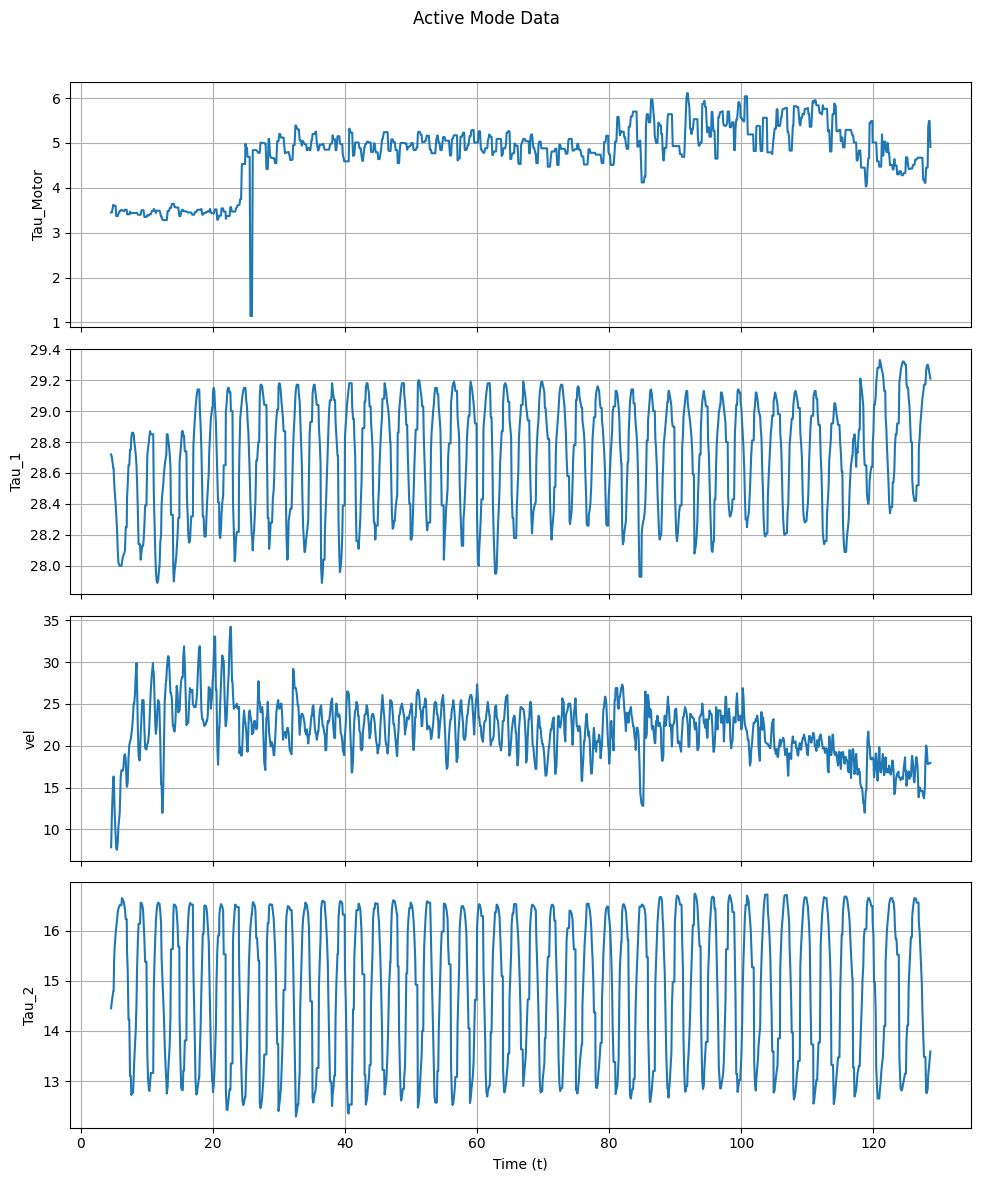

In [ ]:
# prompt: Generate column ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2'] of raw_data['mode'] = Passive in 4 diagram with x-axis is column "t"

# Assuming raw_data and passive_data are already defined as in the provided code.

import matplotlib.pyplot as plt

#Create the plot with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True) # sharex ensures the x-axis is the same for all plots

#Plot each column in a separate subplot
axes[0].plot(active_data['t'], active_data['Tau_Motor'])
axes[0].set_ylabel('Tau_Motor')
axes[0].grid(True)

axes[1].plot(active_data['t'], active_data['Tau_1'])
axes[1].set_ylabel('Tau_1')
axes[1].grid(True)

axes[2].plot(active_data['t'], active_data['vel'])
axes[2].set_ylabel('vel')
axes[2].grid(True)

axes[3].plot(active_data['t'], active_data['Tau_2'])
axes[3].set_ylabel('Tau_2')
axes[3].set_xlabel('Time (t)') #x-axis label only on the bottom plot
axes[3].grid(True)


plt.suptitle('Active Mode Data') # overall title for the subplots
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent overlapping
plt.show()

In [ ]:
turn = 3
try:
    os.mkdir(work_dir/'figures/turn {}'.format(turn))
except:
    pass
view_data = raw_data[raw_data["turn"] == turn]
# Quick view of the data
print('\n____________ Some first data examples ____________')
print(view_data.head(3))
print('\n____________ Some last data examples ____________')
print(view_data.tail(3))
print('\n____________ Statistics of numeric features ____________')
print(view_data.describe())

# # Specify the path and name of the file
# file_path = work_dir/"figures/turn {0}/turn_{0}_{1}_Level_{2}.txt".format(turn,view_data['mode'].iloc[0],view_data['level'].iloc[0])
# print(file_path)
# # Open the file in write mode and write the text
# with open(file_path, "w") as file:
#     file.write("turn {}, mode {}, level {}.".format(turn,view_data['mode'].iloc[0],view_data['level'].iloc[0]))



____________ Some first data examples ____________
Empty DataFrame
Columns: [date, t, Tau_Motor, Tau_1, Tau_2, vel, encoder_count, mode, level, turn, period, push_leg, degree, phase, Tau_Motor_deriv, Tau_1_deriv, Tau_2_deriv, vel_deriv]
Index: []

____________ Some last data examples ____________
Empty DataFrame
Columns: [date, t, Tau_Motor, Tau_1, Tau_2, vel, encoder_count, mode, level, turn, period, push_leg, degree, phase, Tau_Motor_deriv, Tau_1_deriv, Tau_2_deriv, vel_deriv]
Index: []

____________ Statistics of numeric features ____________
         t  Tau_Motor  Tau_1  Tau_2  vel  encoder_count  level  turn  period  \
count  0.0        0.0    0.0    0.0  0.0            0.0    0.0   0.0     0.0   
mean   NaN        NaN    NaN    NaN  NaN            NaN    NaN   NaN     NaN   
std    NaN        NaN    NaN    NaN  NaN            NaN    NaN   NaN     NaN   
min    NaN        NaN    NaN    NaN  NaN            NaN    NaN   NaN     NaN   
25%    NaN        NaN    NaN    NaN  NaN       

In [ ]:
# Specify the path and name of the file
file_path = work_dir/"figures/List_turn.txt"
print(file_path)
# Open the file in write mode and write the text
with open(file_path, "w") as file:
  for i in range(1,32):
    view_data = raw_data[raw_data["turn"] == i]
    file.write("turn {}, mode {}, level {}\n".format(i,view_data['mode'].iloc[0],view_data['level'].iloc[0]))

/content/drive/MyDrive/dataset/Cycling_data/figures/List_turn.txt


IndexError: single positional indexer is out-of-bounds

# **1.1. Statistic**




In [ ]:
view_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.tight_layout()
plt.savefig(work_dir/'figures/turn {}/hist_raw_data.png'.format(turn), format='png', dpi=300) # must save before show()
# plt.show()

NameError: name 'view_data' is not defined

In [ ]:
def moving_average(x, w):
    """
    Average filter for reduce noise

    Args:
        x: Input array
        w: window size

    Returns:
        Filter array
    """
    return np.convolve(x, np.ones(w), 'same') / w

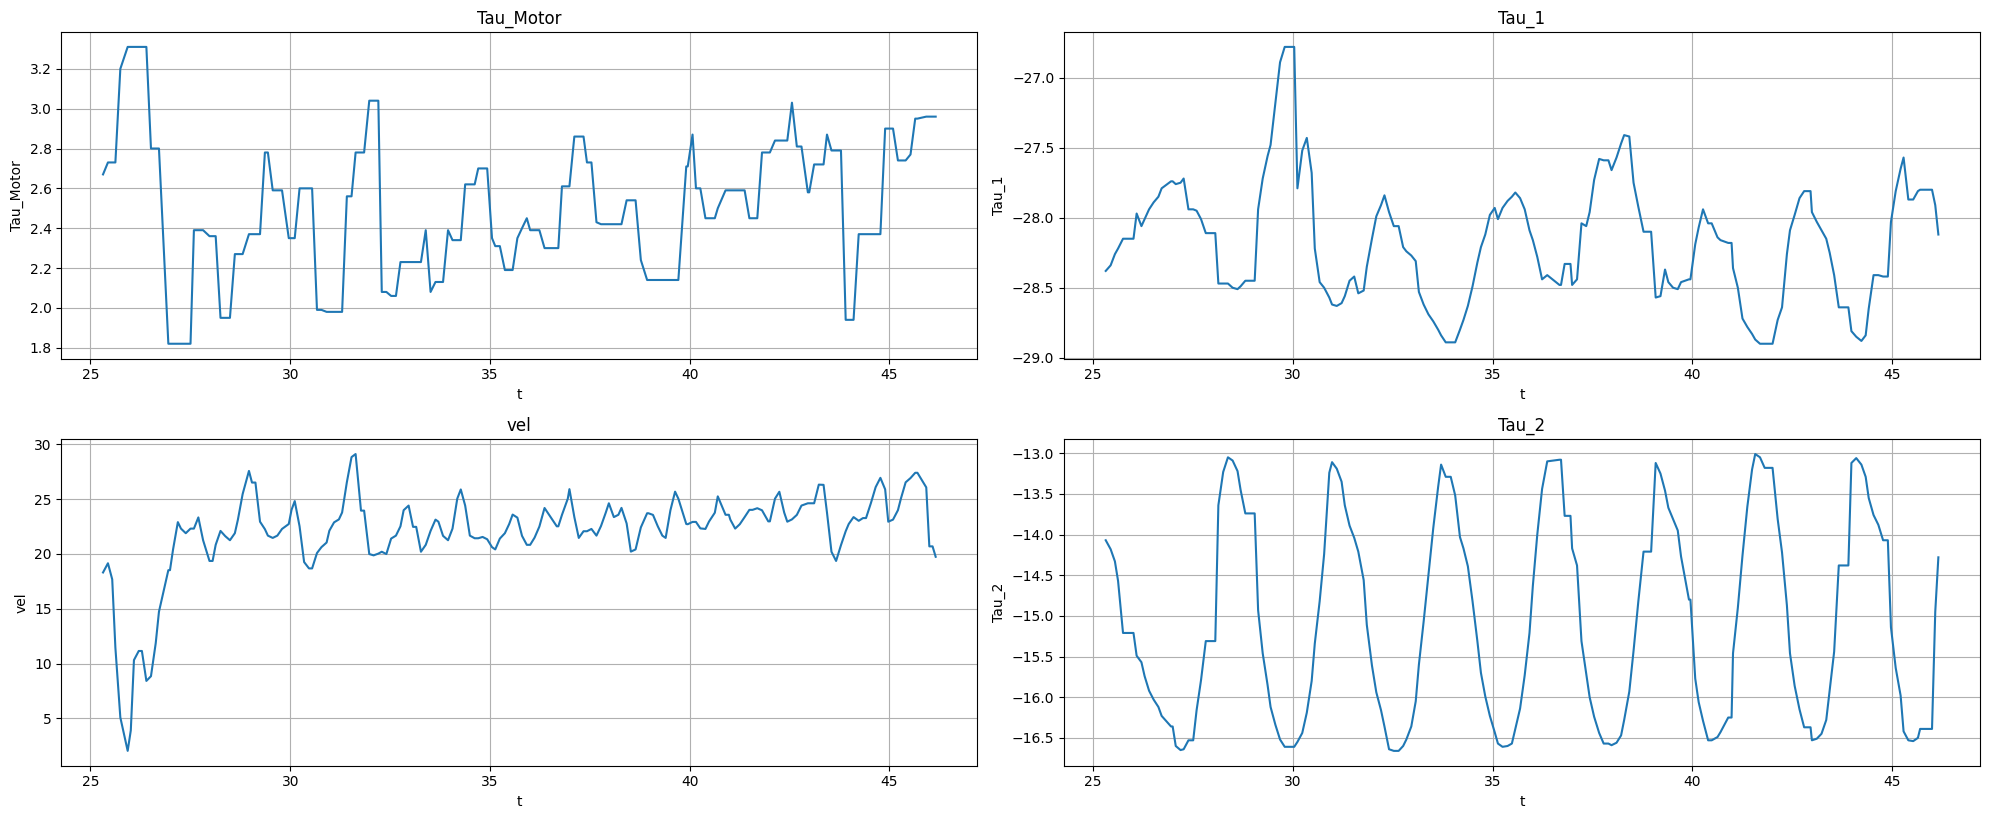

In [ ]:
columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']

# Create a plot for each specified column with 't' as the x-axis
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

for i, col in enumerate(columns_to_plot, start=1):
    plt.subplot(4, 2, i)  # Creates a 4x2 grid for subplots, adjust if you have a different number of columns
    plt.plot(view_data['t'], view_data[col], label=col)
    plt.xlabel('t')
    plt.ylabel(col)
    plt.title(f'{col}')
    plt.grid(True)
plt.tight_layout()  # Adjust layout to avoid overlapping plots
plt.savefig(work_dir/'figures/turn {}/view_data.png'.format(turn), format='png', dpi=300) # must save before show()
plt.show()

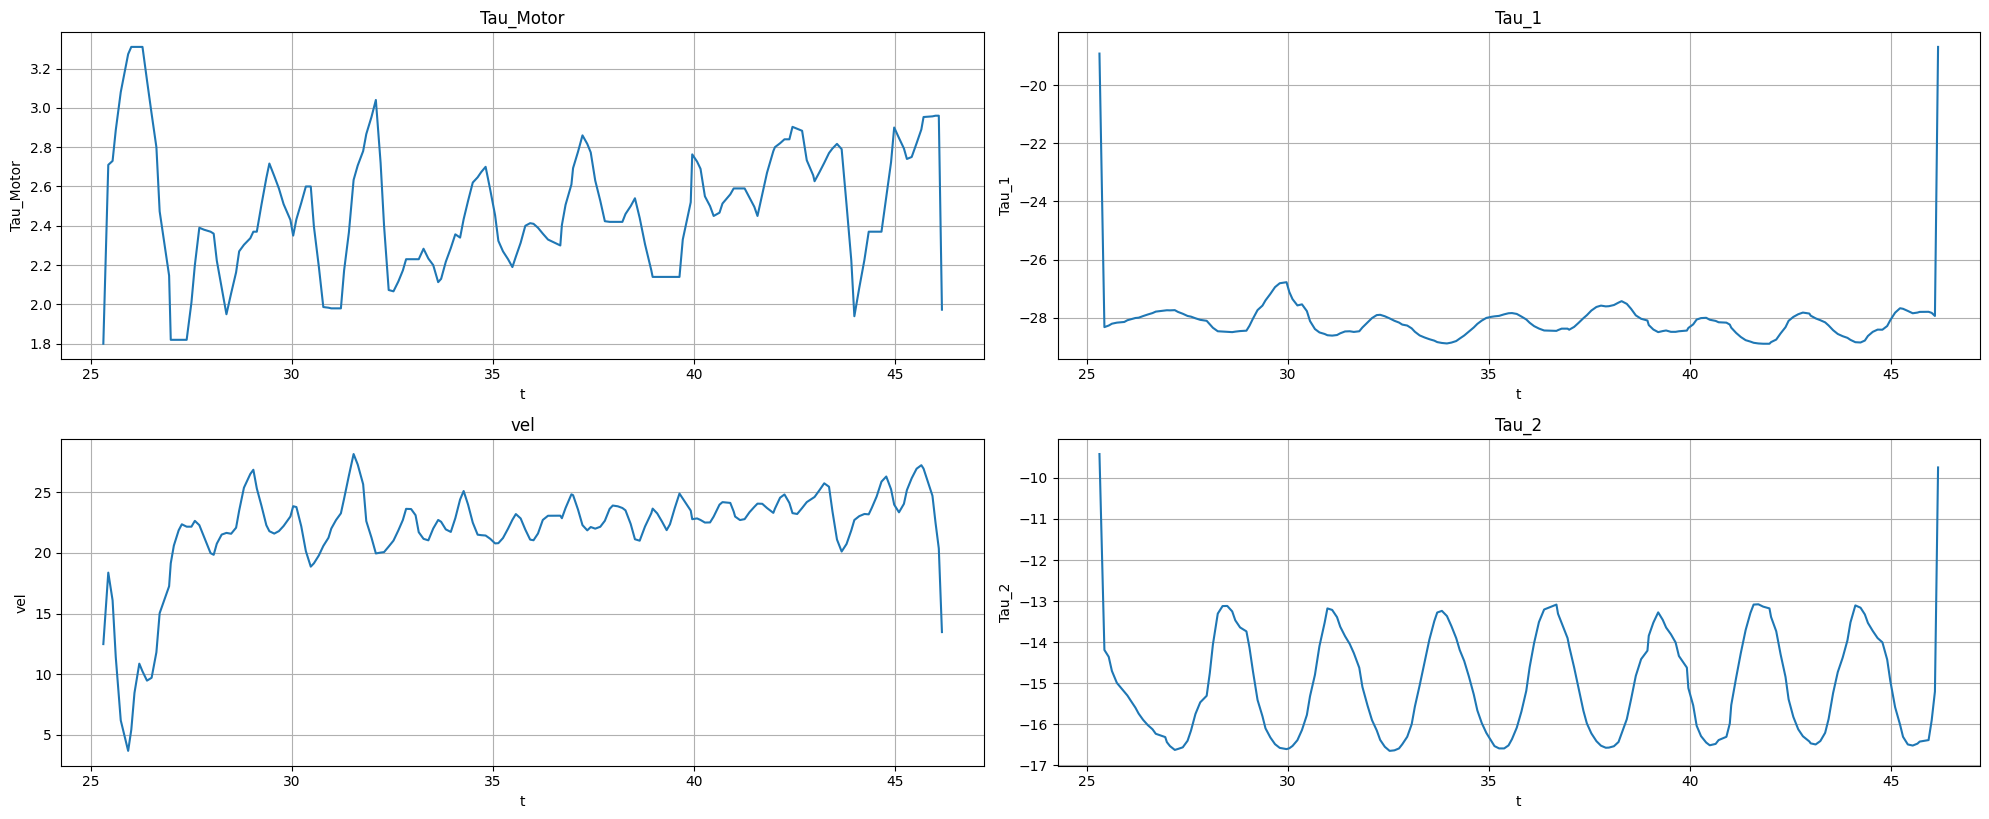

In [ ]:
columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']

# Create a plot for each specified column with 't' as the x-axis
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

for i, col in enumerate(columns_to_plot, start=1):
    filter_data = moving_average(view_data[col],3)
    plt.subplot(4, 2, i)  # Creates a 4x2 grid for subplots, adjust if you have a different number of columns
    plt.plot(view_data['t'], filter_data, label=col)
    plt.xlabel('t')
    plt.ylabel(col)
    plt.title(f'{col}')
    plt.grid(True)
plt.tight_layout()  # Adjust layout to avoid overlapping plots
plt.savefig(work_dir/'figures/turn {}/view_data_filter.png'.format(turn), format='png', dpi=300) # must save before show()
plt.show()

# **1.2. Spectrum analysis and Temporal characteristics**

In [ ]:
def remove_dc(data):
  """
  Hàm loại bỏ thành phần tần số 0 khỏi dữ liệu

  Args:
    data: Mảng dữ liệu đầu vào

  Returns:
    Mảng dữ liệu sau khi loại bỏ thành phần DC
  """

  mean_value = np.mean(data)
  data_without_dc = data - mean_value
  return data_without_dc

def extract_peaks(freq, fft_result, num_peaks=1):
  """
  Hàm trích xuất các đỉnh tần số lớn nhất

  Args:
    freq: Mảng chứa các tần số
    fft_result: Kết quả biến đổi Fourier
    num_peaks: Số lượng đỉnh tần số cần trích xuất

  Returns:
    Danh sách các đỉnh tần số
  """

  # Tìm các chỉ số của các đỉnh
  peak_indices = np.argsort(np.abs(fft_result))[-num_peaks:]

  # Trích xuất các tần số tương ứng
  peak_freqs = freq[peak_indices]

  return peak_freqs

def remove_peaks(data, sampling_rate, peak_freqs):
  """
  Hàm loại bỏ các đỉnh tần số khỏi dữ liệu

  Args:
    data: Dữ liệu đầu vào
    sampling_rate: Tần số lấy mẫu
    peak_freqs: Danh sách các đỉnh tần số cần loại bỏ

  Returns:
    Dữ liệu sau khi loại bỏ các đỉnh tần số
  """

  # Tính biến đổi Fourier
  fft_result = fft(data)
  freqs = fftfreq(len(data), 1/sampling_rate)

  # Tìm các chỉ số tương ứng với các đỉnh tần số cần loại bỏ
  indices_to_remove = np.isin(freqs, peak_freqs)

  # Thiết lập các giá trị tại các đỉnh tần số về 0
  fft_result[indices_to_remove] = 0

  # Tính biến đổi Fourier nghịch để lấy lại tín hiệu
  filtered_data = np.real(np.fft.ifft(fft_result))

  return filtered_data

def remove_low_amplitude_components(data, fs, threshold):
  """
  Hàm loại bỏ các thành phần tần số có biên độ nhỏ hơn ngưỡng

  Args:
    data: Dữ liệu đầu vào
    fs: Tần số lấy mẫu
    threshold: Ngưỡng biên độ

  Returns:
    Dữ liệu sau khi lọc
  """

  # Tính biến đổi Fourier
  fft_result = fft(data)

  # Tính tần số tương ứng với mỗi điểm trong phổ
  freqs = np.fft.fftfreq(len(data), 1/fs)

  # Tạo mặt nạ
  mask = np.abs(fft_result) > threshold
  filtered_fft = fft_result * mask

  # Tính biến đổi Fourier nghịch
  filtered_data = np.real(ifft(filtered_fft))

  return filtered_data

Sampling rate: 4
Max freq: 0.0
list pick freqs: [-0.08376963 -0.23036649  0.23036649 -0.18848168  0.18848168 -0.20942408
  0.20942408 -0.02094241  0.02094241  0.10471204 -0.10471204  0.14659686
 -0.14659686  0.06282723 -0.06282723  0.04188482 -0.04188482  0.16753927
 -0.16753927  0.        ]


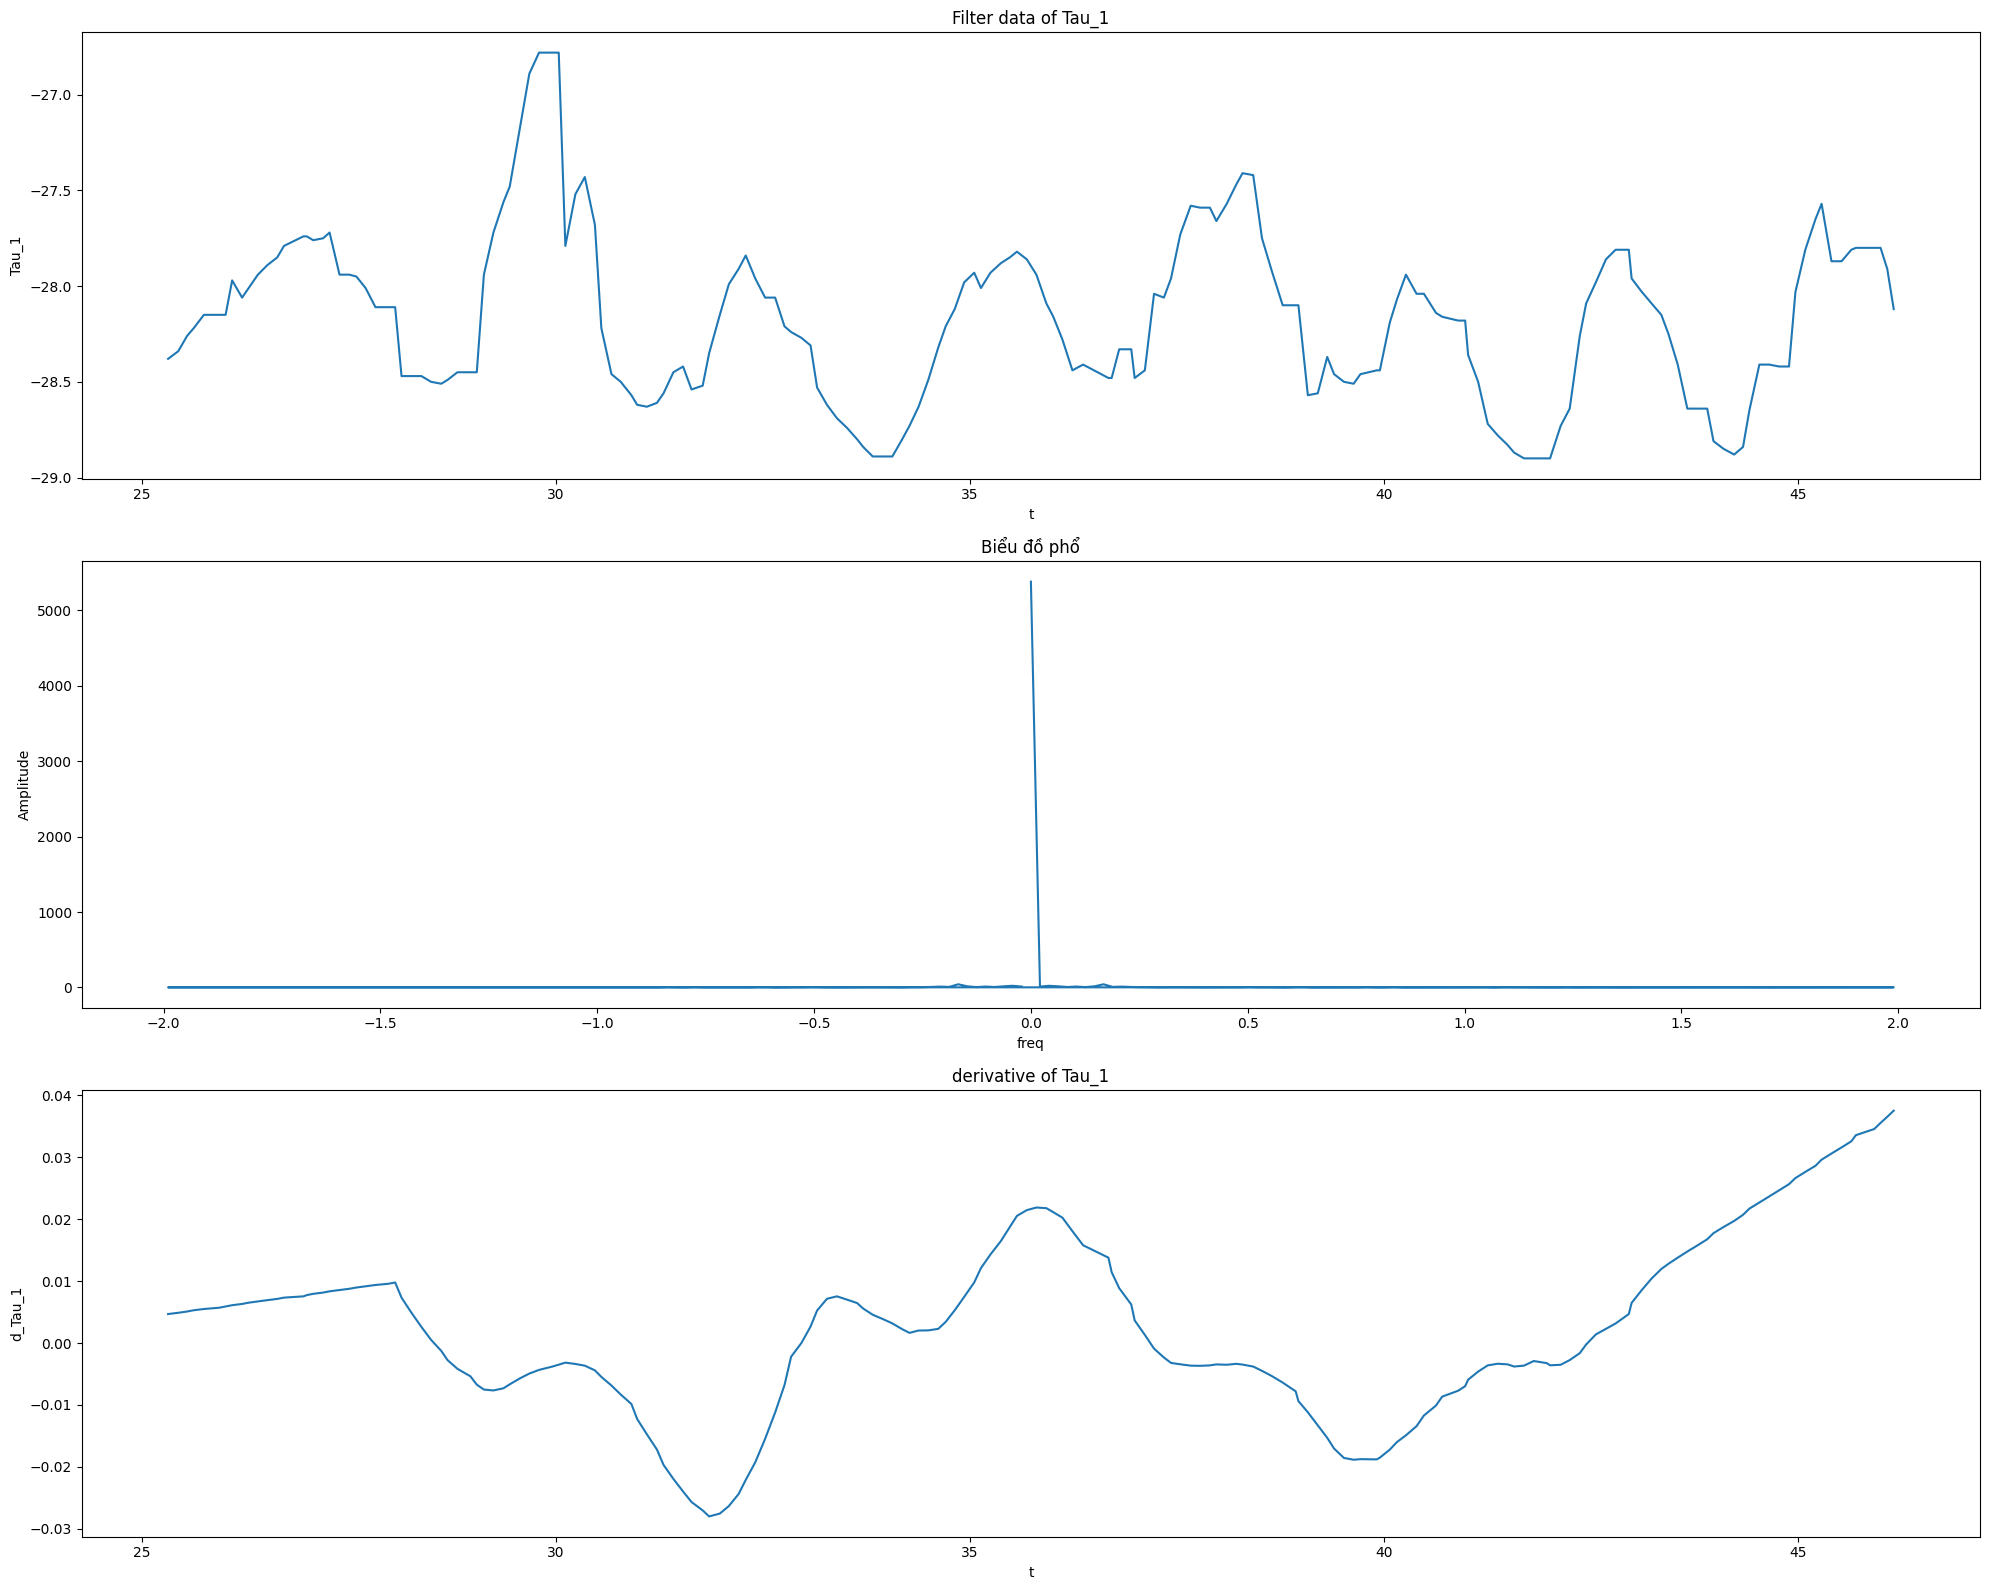

In [ ]:
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import savgol_filter

sampling_rate = int(len(view_data['t'])/max(view_data['t']))
print("Sampling rate:", sampling_rate)
columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']
view_col = columns_to_plot[1]
try:
    os.mkdir(work_dir/'figures/turn {}/{} feature'.format(turn,view_col))
except:
    pass
filtered_data = moving_average(view_data[view_col], 1)

# Fourier transform
fft_result = fft(filtered_data)
freqs = fftfreq(len(filtered_data), 1/sampling_rate)

# Max frequency
idx = np.argmax(np.abs(fft_result))
freq = freqs[idx]
list_freq = extract_peaks(freqs, fft_result, 20)
print("Max freq:", freq)
print("list pick freqs:", list_freq)
# Derivaive
derivative = savgol_filter(filtered_data, window_length=51, polyorder=2, deriv=1)

# Vẽ biểu đồ
plt.figure(figsize=(20, 16))

plt.subplot(3, 1, 1)
plt.plot(view_data['t'], filtered_data)
plt.title('Filter data of {}'.format(view_col))
plt.xlabel('t')
plt.ylabel(view_col)

plt.subplot(3, 1, 2)
plt.plot(freqs, np.abs(fft_result))
plt.title('Biểu đồ phổ')
plt.xlabel('freq')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(view_data['t'], derivative)
plt.title('derivative of {}'.format(view_col))
plt.xlabel('t')
plt.ylabel('d_{}'.format(view_col))

plt.tight_layout()
plt.savefig(work_dir/'figures/turn {}/{}_feature.png'.format(turn, view_col), format='png', dpi=300) # must save before show()
plt.show()

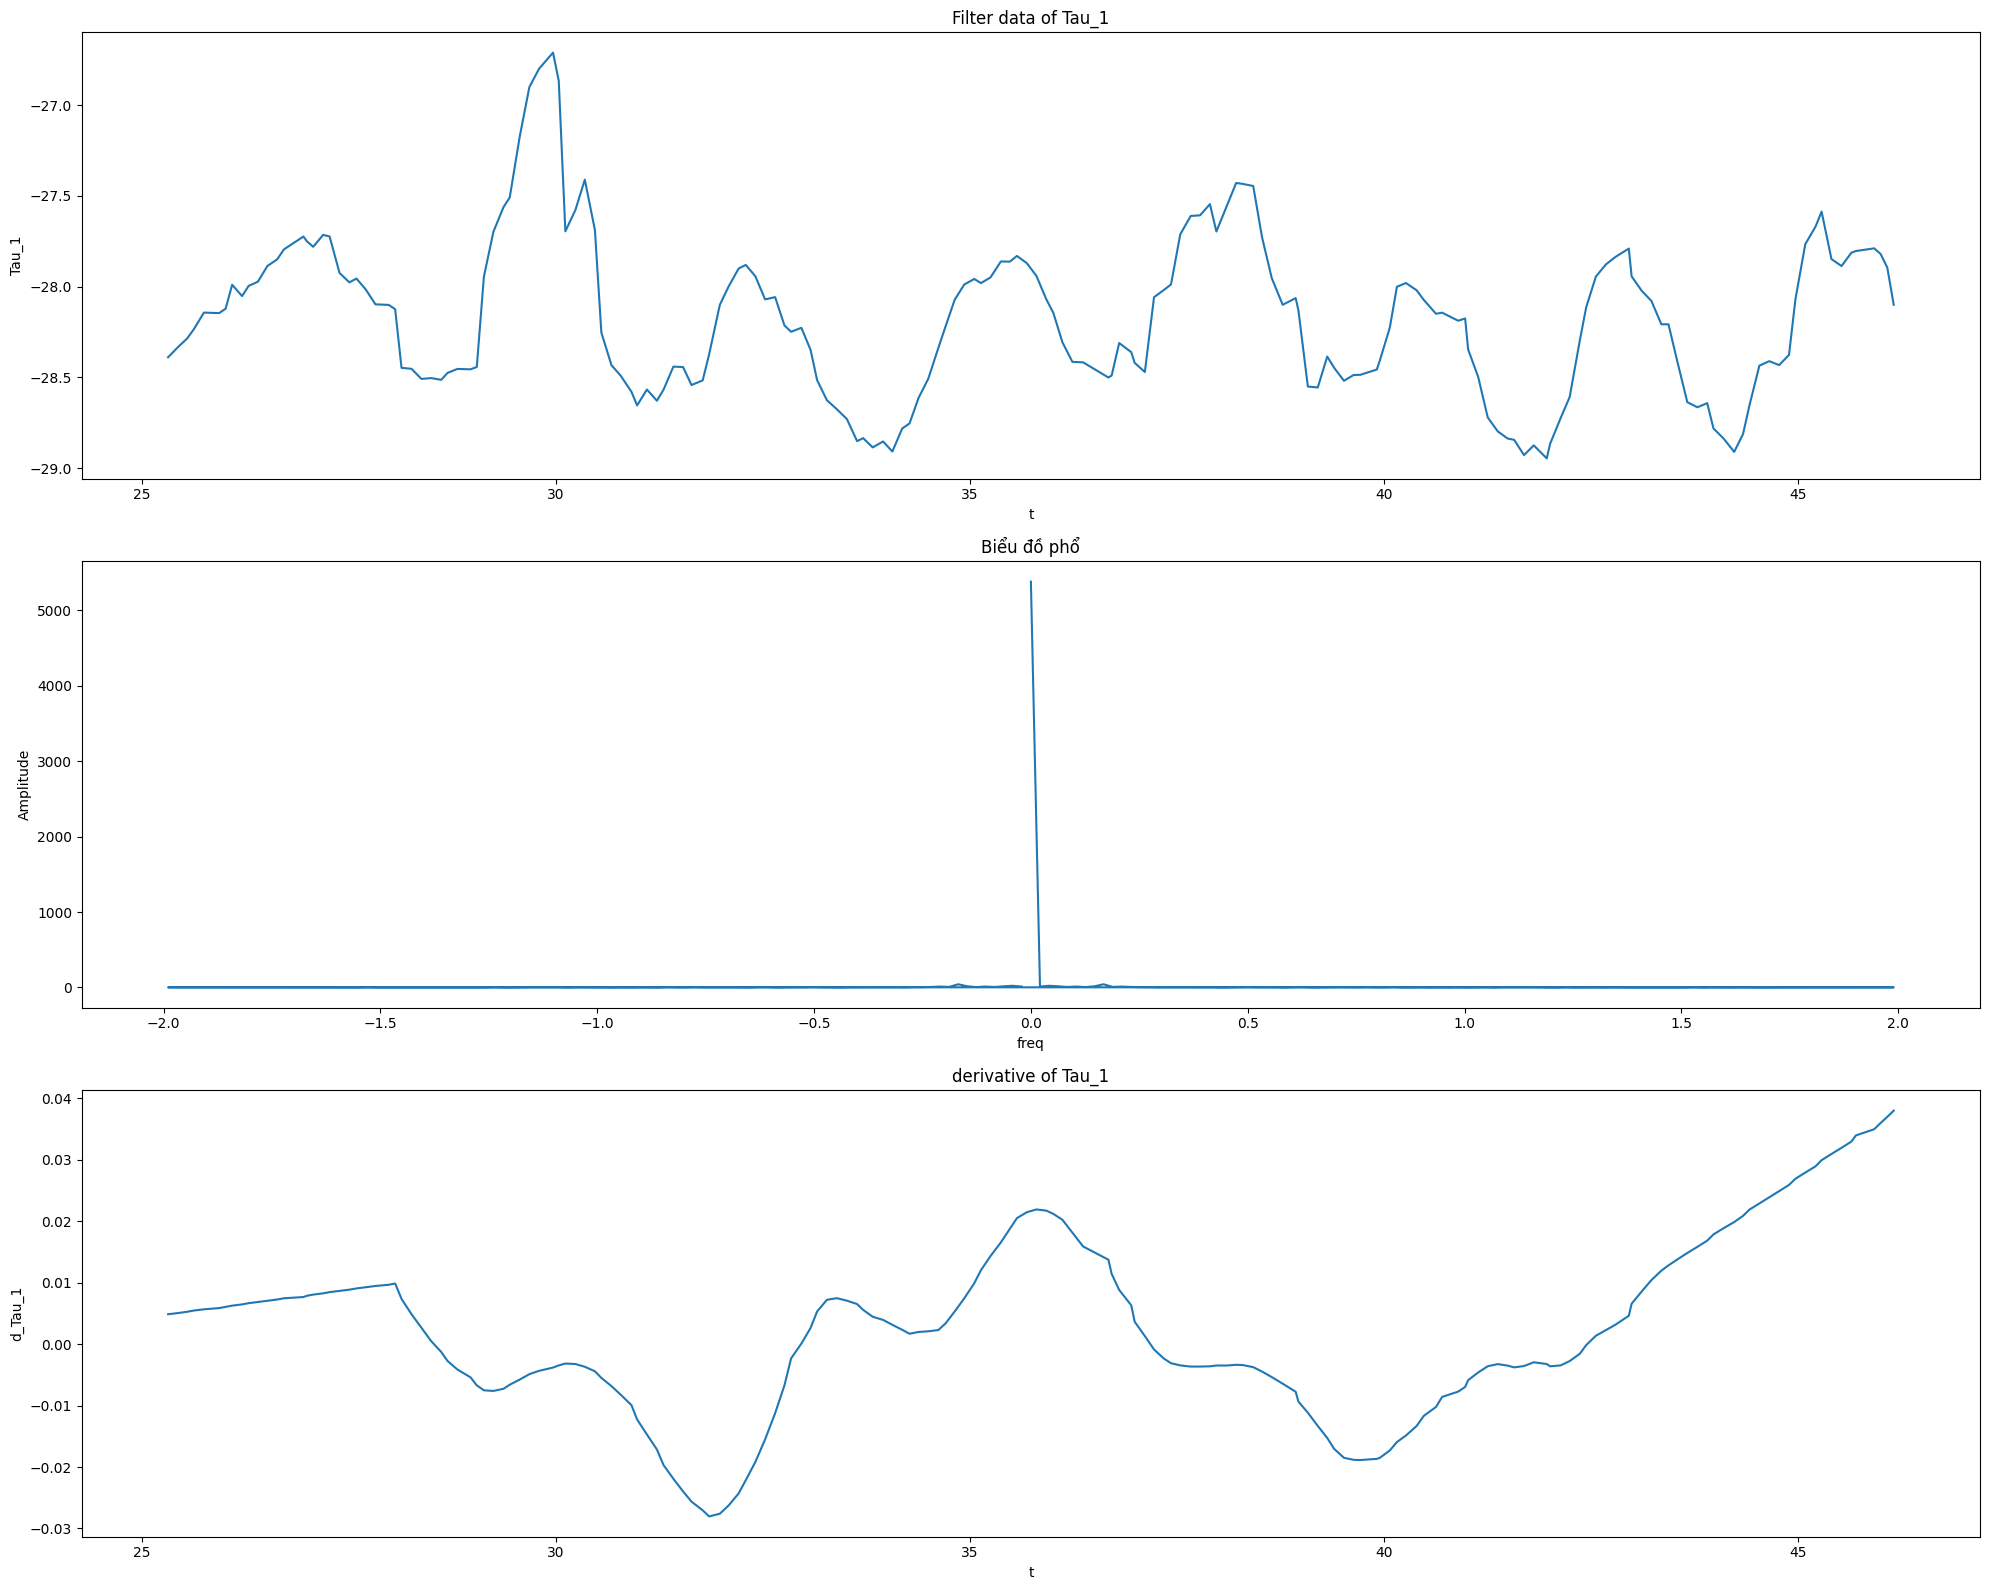

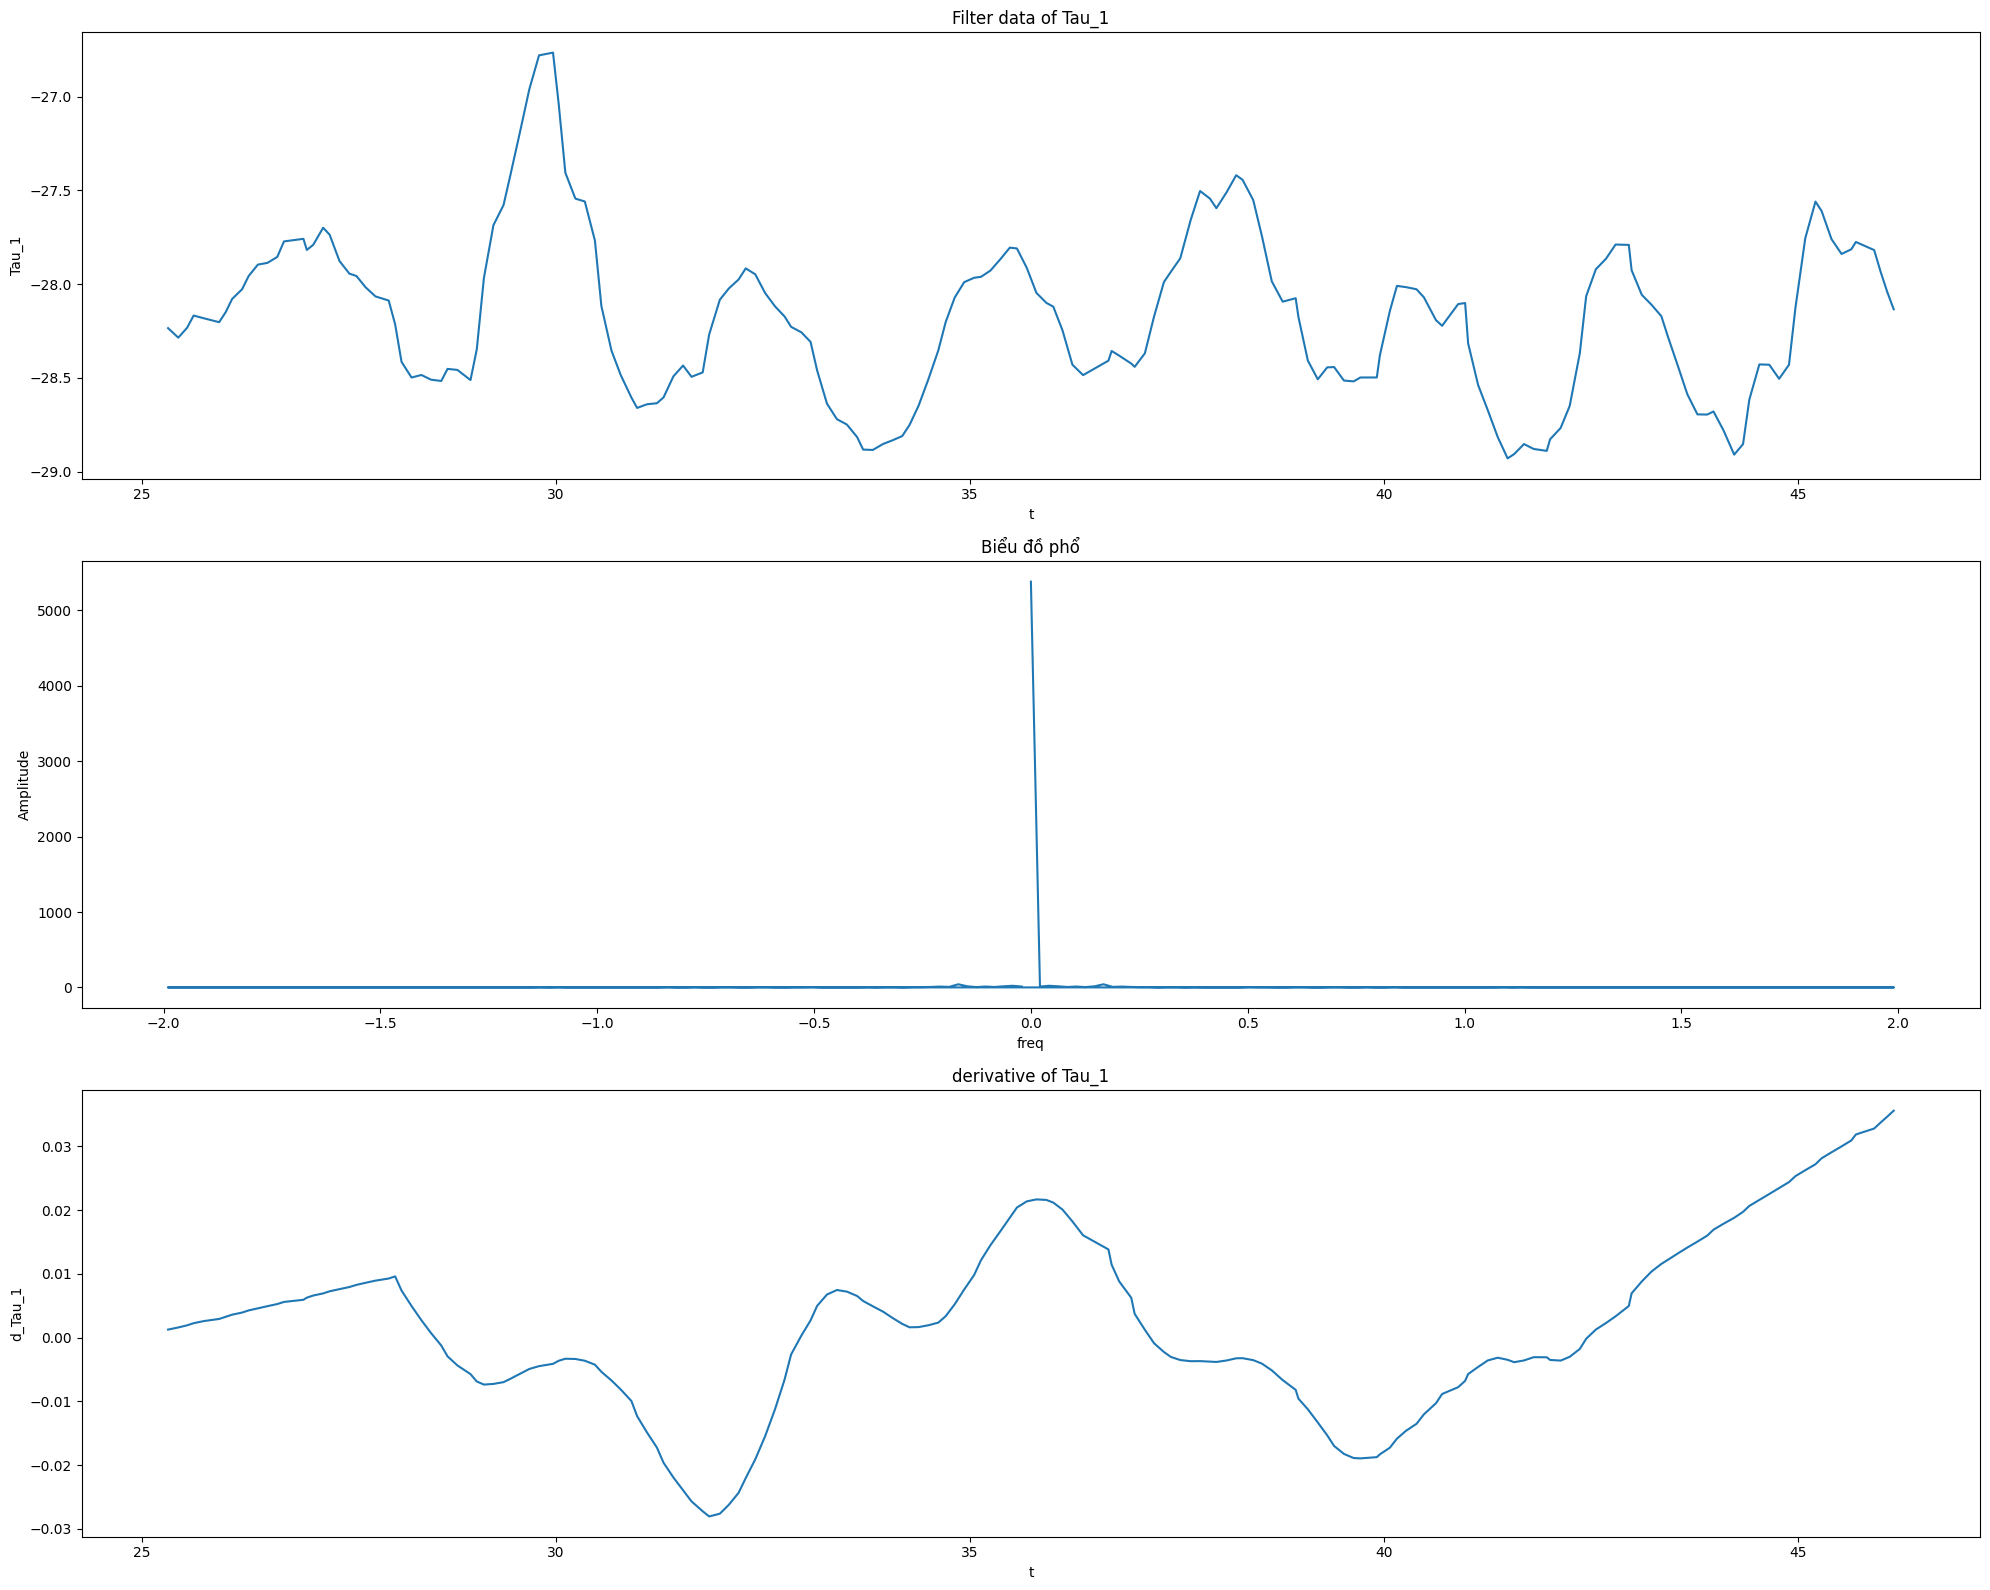

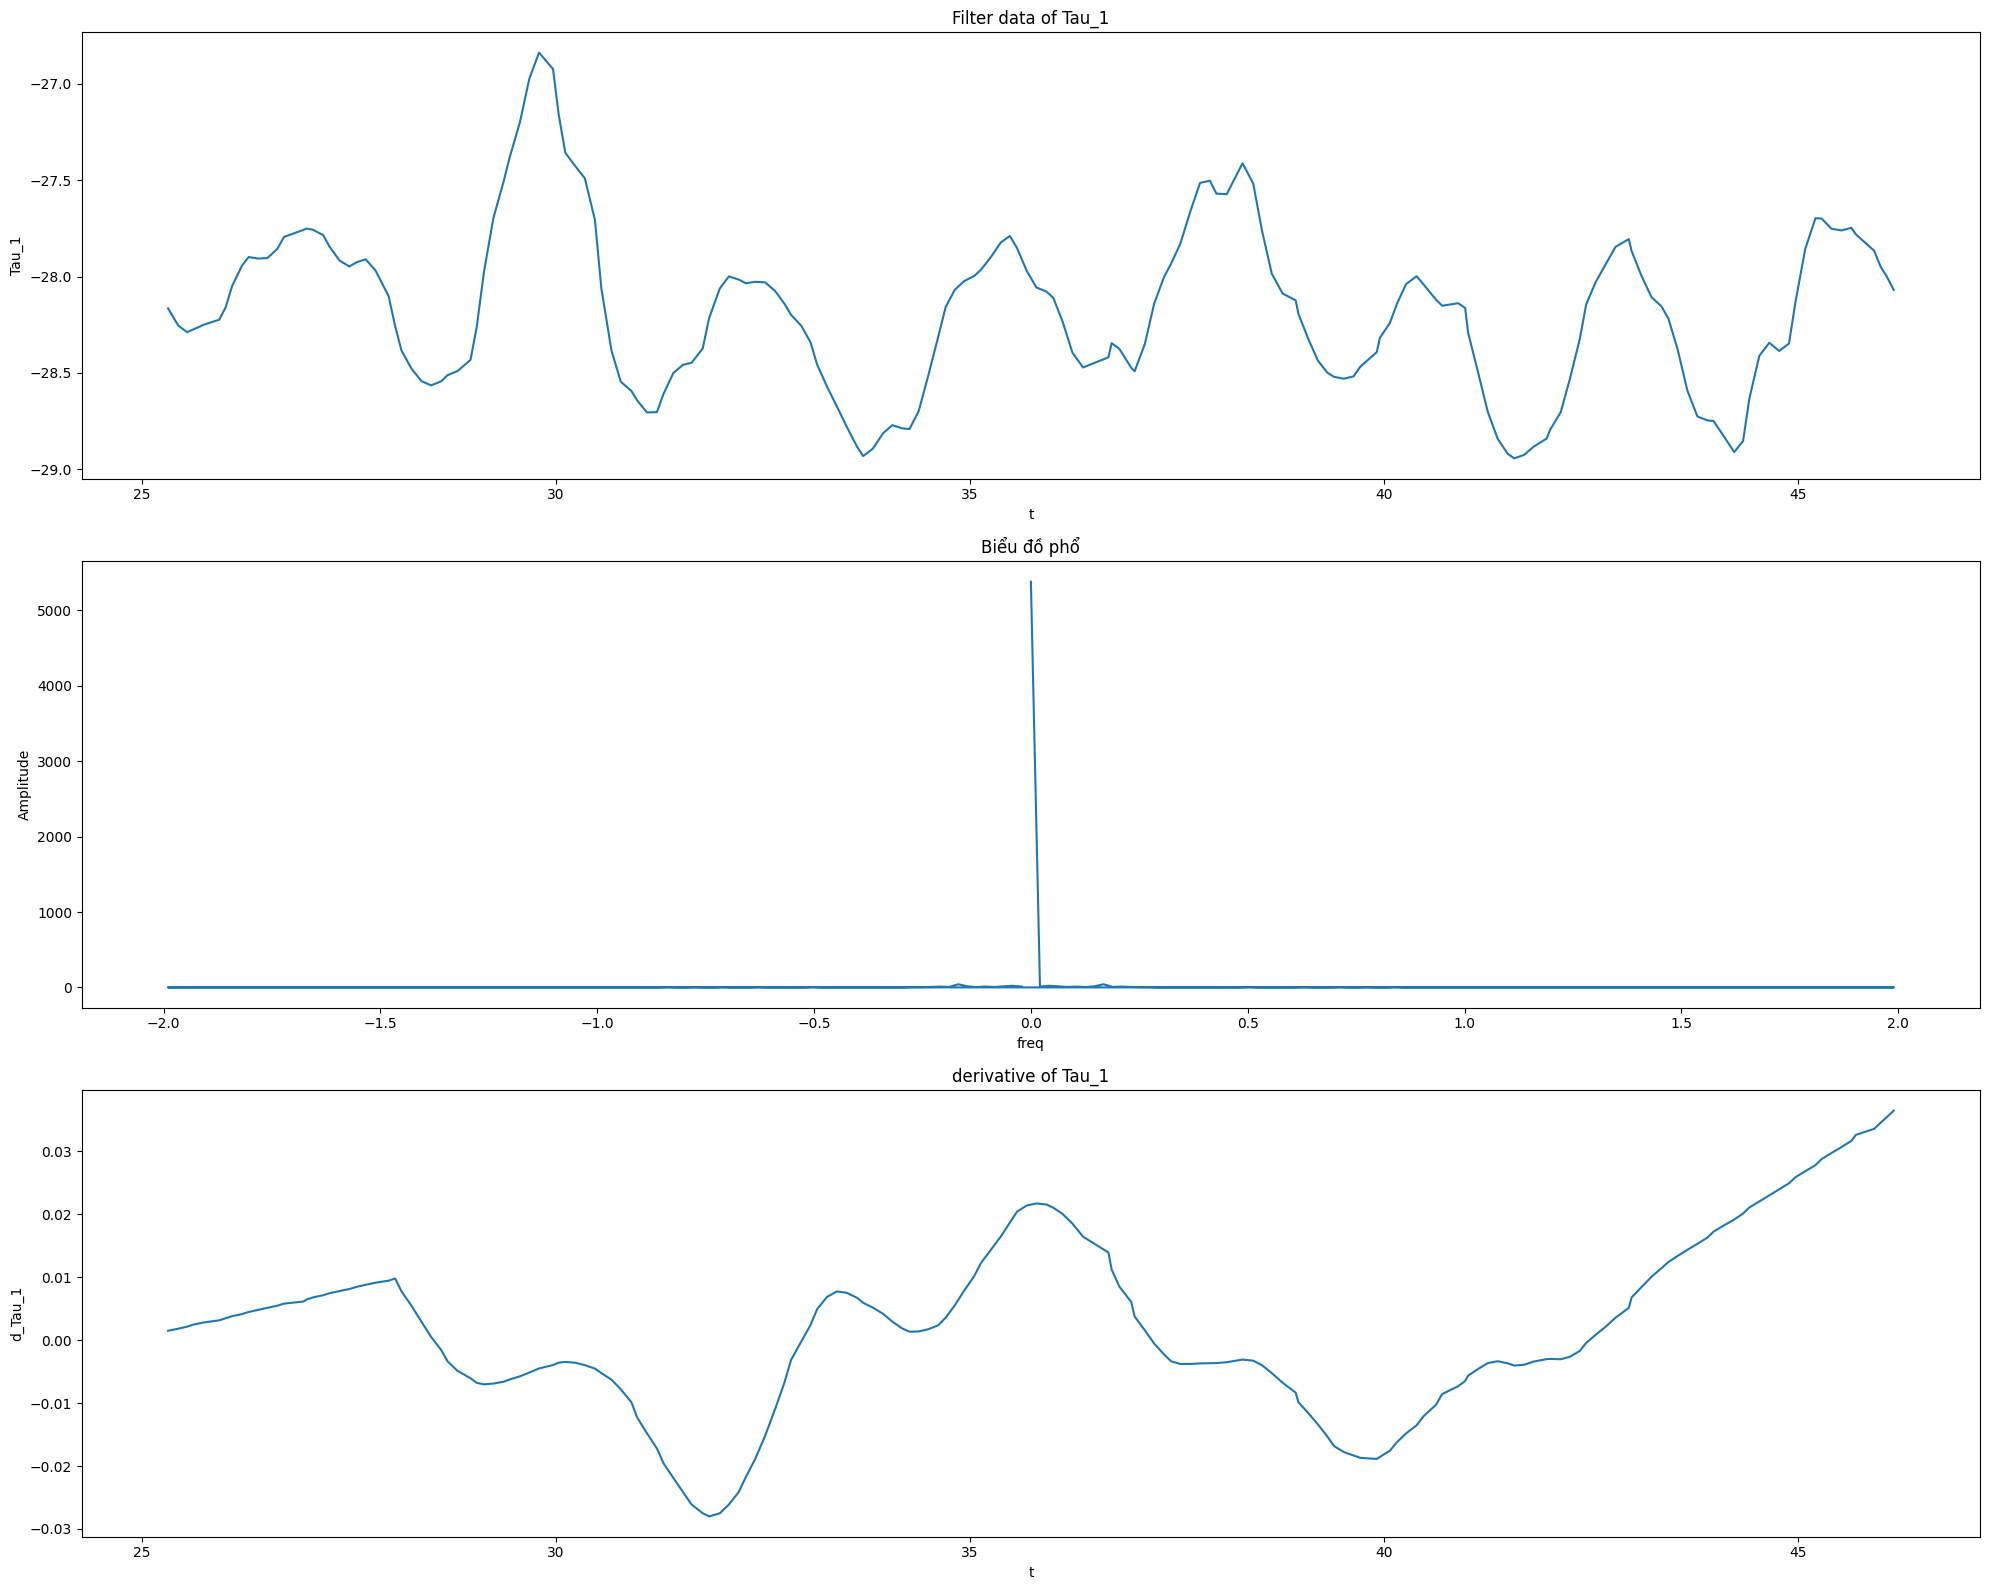

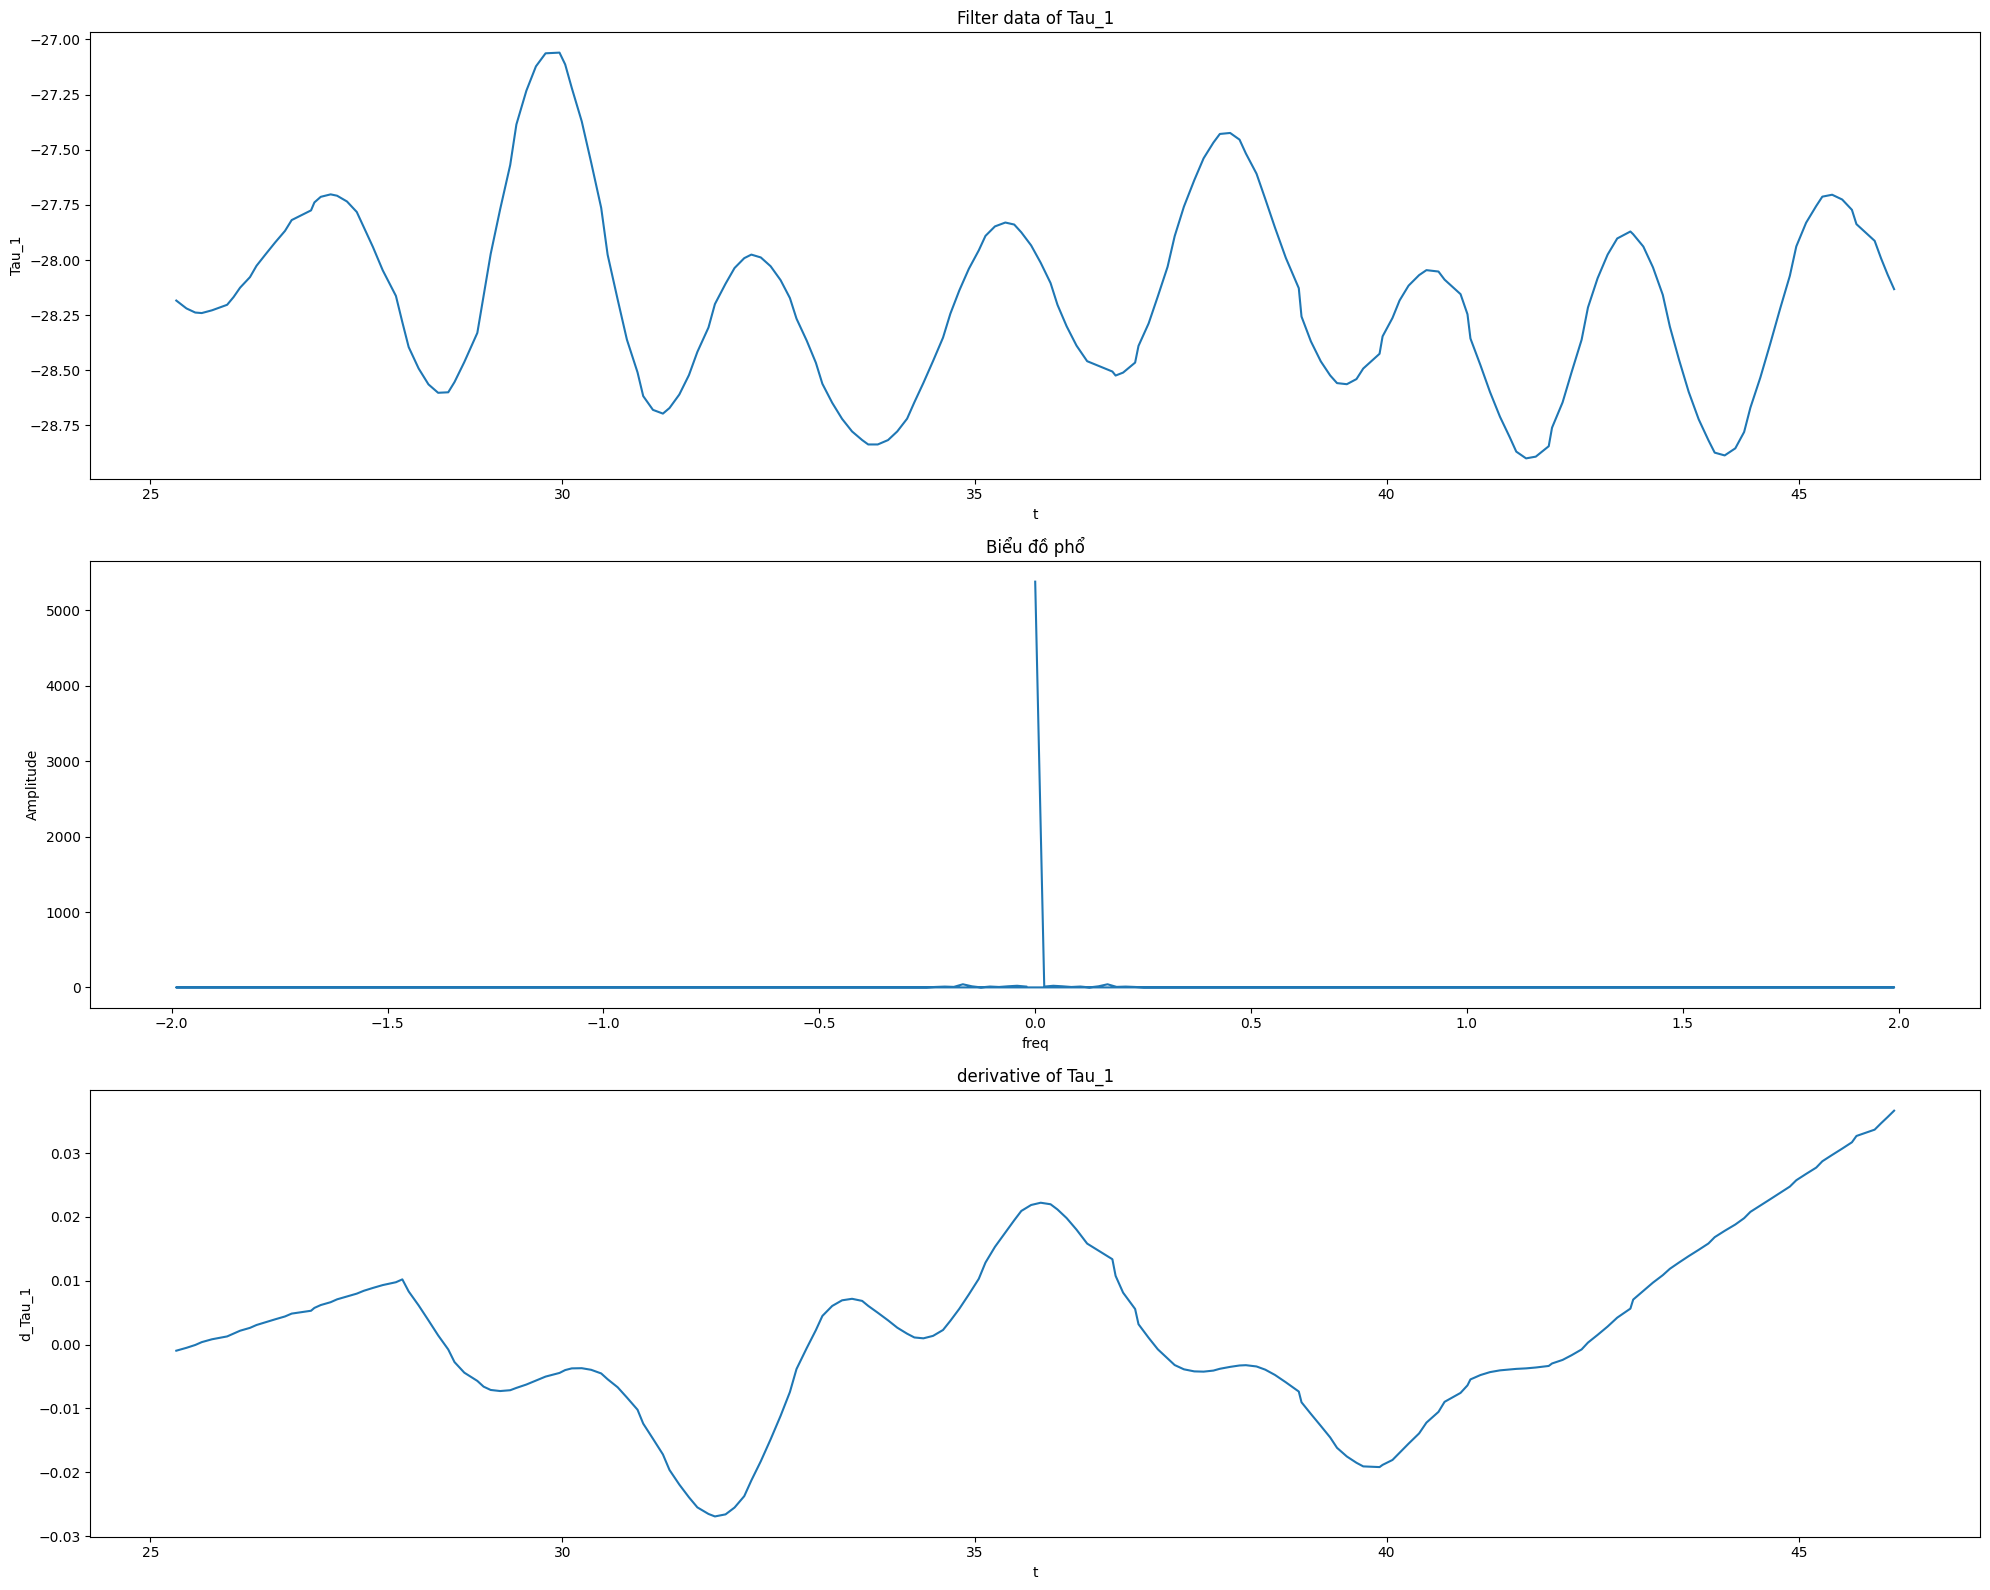

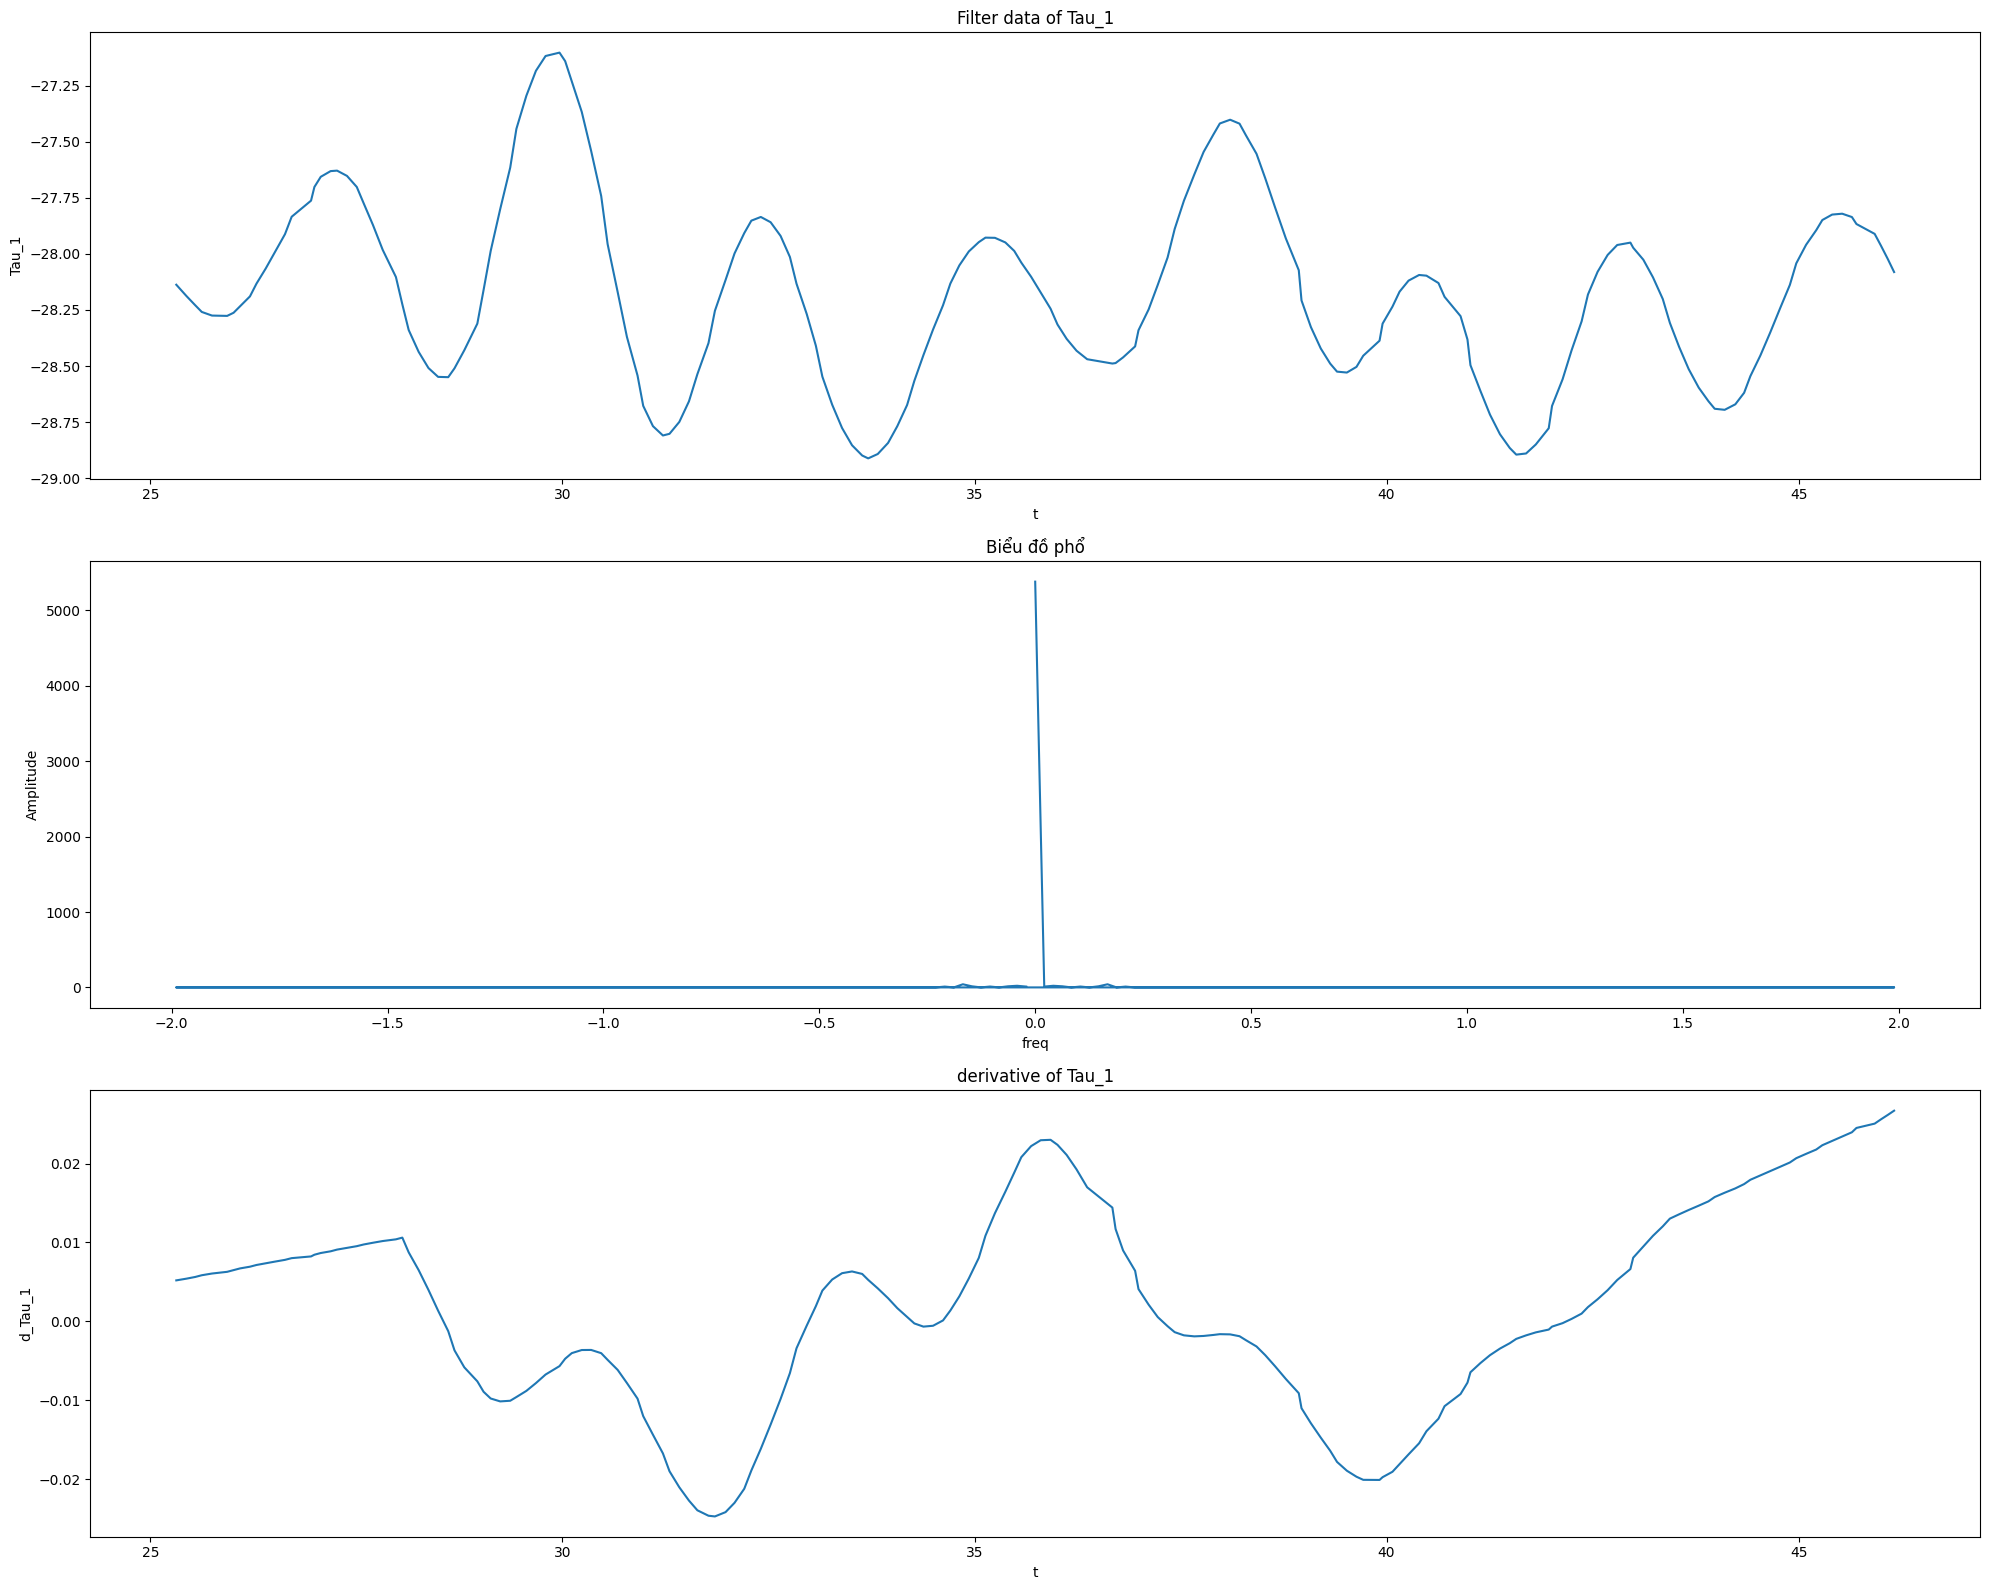

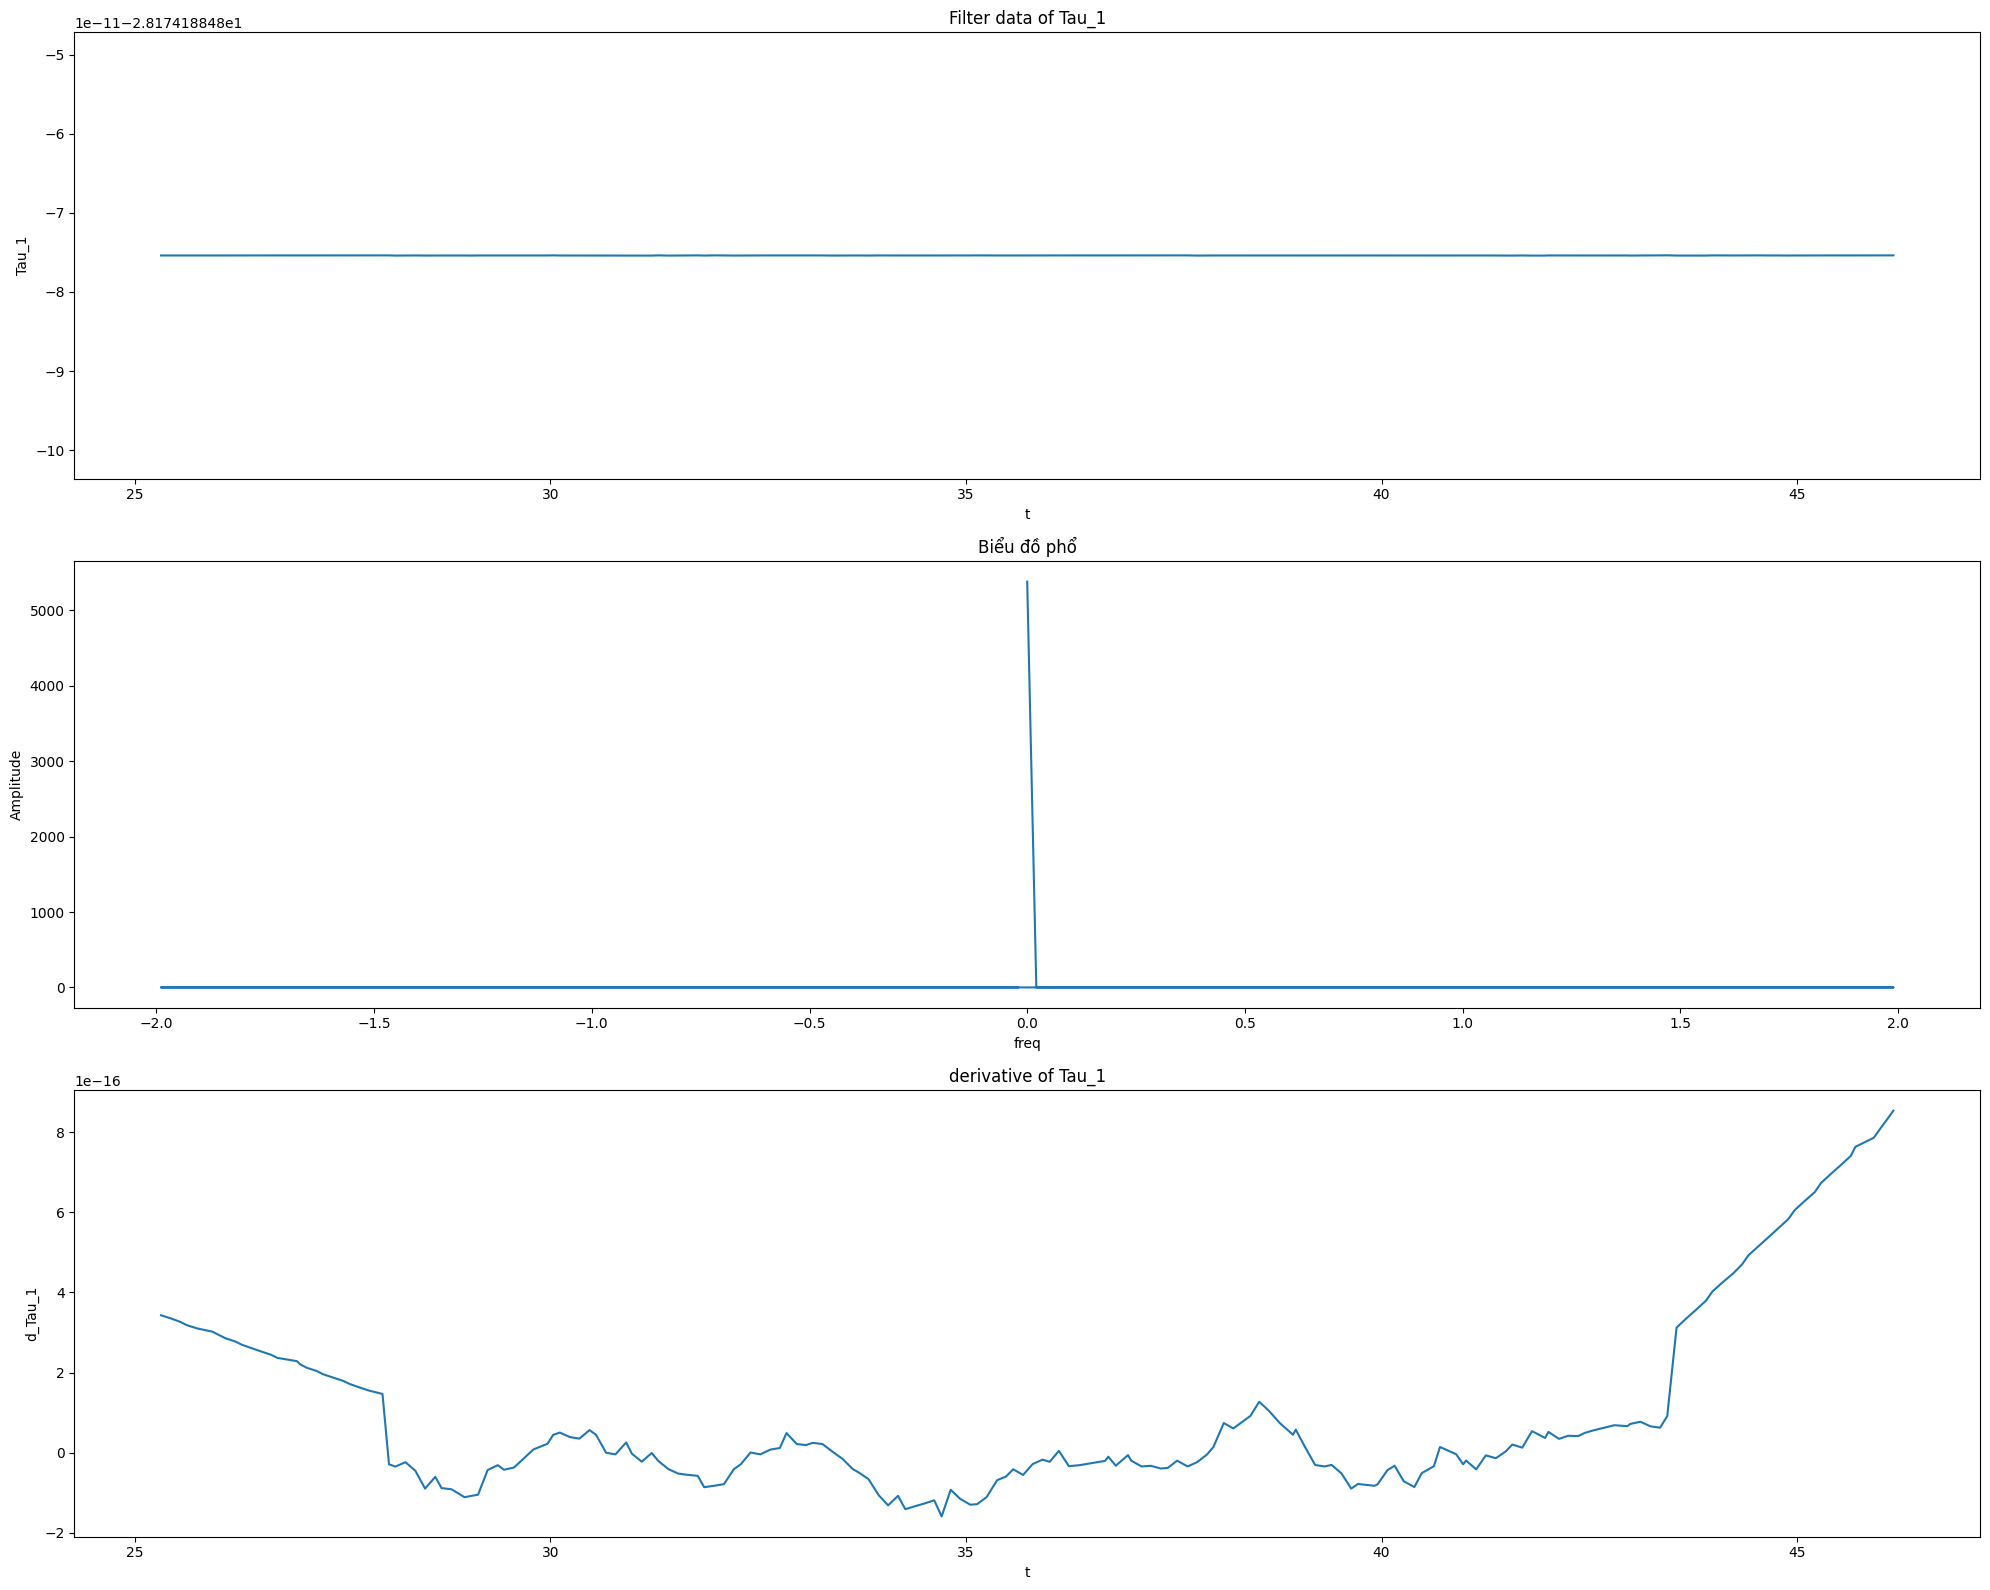

In [ ]:
l_threshold = [1,2,3,5,10,50]
# l_threshold = [5,100,200]
for threshold in l_threshold:
    filtered_data = remove_low_amplitude_components(moving_average(view_data[view_col], 1), sampling_rate, threshold)

    # Fourier transform
    fft_result = fft(filtered_data)
    freqs = fftfreq(len(filtered_data), 1/sampling_rate)

    # Max frequency
    idx = np.argmax(np.abs(fft_result))
    freq = freqs[idx]

    # Derivaive
    derivative = savgol_filter(filtered_data, window_length=51, polyorder=2, deriv=1)

    # Vẽ biểu đồ
    plt.figure(figsize=(20, 16))

    plt.subplot(3, 1, 1)
    plt.plot(view_data['t'], filtered_data)
    plt.title('Filter data of {}'.format(view_col))
    plt.xlabel('t')
    plt.ylabel(view_col)

    plt.subplot(3, 1, 2)
    plt.plot(freqs, np.abs(fft_result))
    plt.title('Biểu đồ phổ')
    plt.xlabel('freq')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(view_data['t'], derivative)
    plt.title('derivative of {}'.format(view_col))
    plt.xlabel('t')
    plt.ylabel('d_{}'.format(view_col))

    plt.tight_layout()
    plt.savefig(work_dir/'figures/turn {}/{} feature/fft_filter_threshold_{}.png'.format(turn, view_col, threshold), format='png', dpi=300) # must save before show()
    plt.show()

In [ ]:
turn = 31
try:
    os.mkdir(work_dir/'figures/turn {}'.format(turn))
except:
    pass
view_data = raw_data[raw_data["turn"] == turn]
print("Turn: ", turn)

# Histogram
view_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.tight_layout()
plt.savefig(work_dir/'figures/turn {}/hist_raw_data.png'.format(turn), format='png', dpi=300) # must save before show()

columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']

# Origin data
# Create a plot for each specified column with 't' as the x-axis
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

for i, col in enumerate(columns_to_plot, start=1):
    plt.subplot(4, 2, i)  # Creates a 4x2 grid for subplots, adjust if you have a different number of columns
    plt.plot(view_data['t'], view_data[col], label=col)
    plt.xlabel('t')
    plt.ylabel(col)
    plt.title(f'{col}')
    plt.grid(True)
plt.tight_layout()  # Adjust layout to avoid overlapping plots
plt.savefig(work_dir/'figures/turn {}/view_data.png'.format(turn), format='png', dpi=300) # must save before show()
print("Save Origin data!")

# Filter data
# Create a plot for each specified column with 't' as the x-axis
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

for i, col in enumerate(columns_to_plot, start=1):
    filter_data = moving_average(view_data[col],3)
    plt.subplot(4, 2, i)  # Creates a 4x2 grid for subplots, adjust if you have a different number of columns
    plt.plot(view_data['t'], filter_data, label=col)
    plt.xlabel('t')
    plt.ylabel(col)
    plt.title(f'{col}')
    plt.grid(True)
plt.tight_layout()  # Adjust layout to avoid overlapping plots
plt.savefig(work_dir/'figures/turn {}/view_data_filter.png'.format(turn), format='png', dpi=300) # must save before show()
print("Save filter data!")


# Eatract feature
sampling_rate = int(len(view_data['t'])/max(view_data['t']))
for view_col in columns_to_plot:
    try:
        os.mkdir(work_dir/'figures/turn {}/{} feature'.format(turn,view_col))
    except:
        pass
    print("Run feature {}!".format(view_col))
    filtered_data = moving_average(view_data[view_col], 3)

    # Fourier transform
    fft_result = fft(filtered_data)
    freqs = fftfreq(len(filtered_data), 1/sampling_rate)

    # Max frequency
    idx = np.argmax(np.abs(fft_result))
    freq = freqs[idx]
    list_freq = extract_peaks(freqs, fft_result, 20)
    # print("Max freq:", freq)
    # print("list pick freqs:", list_freq)
    # Derivaive
    derivative = savgol_filter(filtered_data, window_length=51, polyorder=2, deriv=1)

    # Vẽ biểu đồ
    plt.figure(figsize=(20, 16))

    plt.subplot(3, 1, 1)
    plt.plot(view_data['t'], filtered_data)
    plt.title('Filter data of {}'.format(view_col))
    plt.xlabel('t')
    plt.ylabel(view_col)

    plt.subplot(3, 1, 2)
    plt.plot(freqs, np.abs(fft_result))
    plt.title('Biểu đồ phổ')
    plt.xlabel('freq')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(view_data['t'], derivative)
    plt.title('derivative of {}'.format(view_col))
    plt.xlabel('t')
    plt.ylabel('d_{}'.format(view_col))

    plt.tight_layout()
    plt.savefig(work_dir/'figures/turn {}/{}_feature.png'.format(turn, view_col), format='png', dpi=300) # must save before show()

    if view_col == 'vel':
        l_threshold = [5,100,200]
    else:
        l_threshold = [5,10,50,100]
    print("Take fft image filter!")
    for threshold in l_threshold:
        print("Threshold = {}".format(threshold))
        filtered_data = remove_low_amplitude_components(moving_average(view_data[view_col], 3), sampling_rate, threshold)

        # Fourier transform
        fft_result = fft(filtered_data)
        freqs = fftfreq(len(filtered_data), 1/sampling_rate)

        # Max frequency
        idx = np.argmax(np.abs(fft_result))
        freq = freqs[idx]

        # Derivaive
        derivative = savgol_filter(filtered_data, window_length=51, polyorder=2, deriv=1)

        # Vẽ biểu đồ
        plt.figure(figsize=(20, 16))

        plt.subplot(3, 1, 1)
        plt.plot(view_data['t'], filtered_data)
        plt.title('Filter data of {}'.format(view_col))
        plt.xlabel('t')
        plt.ylabel(view_col)

        plt.subplot(3, 1, 2)
        plt.plot(freqs, np.abs(fft_result))
        plt.title('Biểu đồ phổ')
        plt.xlabel('freq')
        plt.ylabel('Amplitude')

        plt.subplot(3, 1, 3)
        plt.plot(view_data['t'], derivative)
        plt.title('derivative of {}'.format(view_col))
        plt.xlabel('t')
        plt.ylabel('d_{}'.format(view_col))

        plt.tight_layout()
        plt.savefig(work_dir/'figures/turn {}/{} feature/fft_filter_threshold_{}.png'.format(turn, view_col, threshold), format='png', dpi=300) # must save before show()
    print("Save fft image filter!")
print("End!")

# Take image of each feature

In [ ]:
turn = 31
try:
    os.mkdir(work_dir/'figures/turn {}'.format(turn))
except:
    pass
view_data = raw_data[raw_data["turn"] == turn]
print("Turn: ", turn)


columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']


for turn in range(1,32):
    view_data = raw_data[raw_data["turn"] == turn]
    print("Turn: ", turn)
    # Eatract feature
    sampling_rate = int(len(view_data['t'])/max(view_data['t']))
    for view_col in columns_to_plot:
        try:
            os.mkdir(work_dir/'figures/{} feature'.format(view_col))
        except:
            pass
        print("Run feature {}!".format(view_col))
        filtered_data = moving_average(view_data[view_col], 3)

        # Fourier transform
        fft_result = fft(filtered_data)
        freqs = fftfreq(len(filtered_data), 1/sampling_rate)

        # Max frequency
        idx = np.argmax(np.abs(fft_result))
        freq = freqs[idx]
        list_freq = extract_peaks(freqs, fft_result, 20)
        # print("Max freq:", freq)
        # print("list pick freqs:", list_freq)
        # Derivaive
        derivative = savgol_filter(filtered_data, window_length=51, polyorder=2, deriv=1)

        # Vẽ biểu đồ
        plt.figure(figsize=(20, 16))

        plt.subplot(3, 1, 1)
        plt.plot(view_data['t'], filtered_data)
        plt.title('Filter data of {}'.format(view_col))
        plt.xlabel('t')
        plt.ylabel(view_col)

        plt.subplot(3, 1, 2)
        plt.plot(freqs, np.abs(fft_result))
        plt.title('Biểu đồ phổ')
        plt.xlabel('freq')
        plt.ylabel('Amplitude')

        plt.subplot(3, 1, 3)
        plt.plot(view_data['t'], derivative)
        plt.title('derivative of {}'.format(view_col))
        plt.xlabel('t')
        plt.ylabel('d_{}'.format(view_col))

        plt.tight_layout()
        plt.savefig(work_dir/'figures/{} feature/turn_{}.png'.format(view_col, turn), format='png', dpi=300) # must save before show()

print("End!")

Output hidden; open in https://colab.research.google.com to view.